<a href="https://colab.research.google.com/github/DesiGhodi/datasciencecoursera/blob/master/daan881_nsduh_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries and download data

In [ ]:
!pip install dask[dataframe] catboost shap imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 157 kB/s 
     |████████████████████████████████| 569 kB 69.4 MB/s 
     |████████████████████████████████| 140 kB 68.5 MB/s 


In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
from __future__ import annotations
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost.utils import get_confusion_matrix
from dask import delayed
import dask.dataframe as dd
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import urllib.request

In [ ]:
#@title Manually set datatypes that Pandas/Dask cannot guess
dtypes={'ABUPOSHAL': 'float64',
       'ABUPOSINH': 'float64',
       'ABUPOSMTH': 'float64',
       'ABUPOSPNR': 'float64',
       'ABUPOSSED': 'float64',
       'ABUPOSSTM': 'float64',
       'ABUPOSTRQ': 'float64',
       'APPDRGMON2': 'float64',
       'CADRKCOCN2': 'float64',
       'CADRKHALL2': 'float64',
       'CADRKHERN2': 'float64',
       'CADRKINHL2': 'float64',
       'CADRKMETH2': 'float64',
       'COLLENRLFT': 'float64',
       'COLLENRLST': 'float64',
       'DEPENDHAL': 'float64',
       'DEPENDINH': 'float64',
       'DEPENDMTH': 'float64',
       'DEPENDPNR': 'float64',
       'DEPENDSED': 'float64',
       'DEPENDSTM': 'float64',
       'DEPENDTRQ': 'float64',
       'DIFOBTCOC': 'float64',
       'DIFOBTCRK': 'float64',
       'DIFOBTHER': 'float64',
       'DIFOBTLSD': 'float64',
       'DIFOBTMRJ': 'float64',
       'DRVINALCO2': 'float64',
       'DRVINALDRG': 'float64',
       'DRVINMARJ2': 'float64',
        'FILEDATE' : 'string', #svk3
       'GQTYPE2': 'object',
       'GRSKBNGDLY': 'float64',
       'GRSKBNGWK': 'float64',
       'GRSKCIGPKD': 'float64',
       'GRSKCOCMON': 'float64',
       'GRSKCOCWK': 'float64',
       'GRSKHERTRY': 'float64',
       'GRSKHERWK': 'float64',
       'GRSKLSDTRY': 'float64',
       'GRSKLSDWK': 'float64',
       'GRSKMRJMON': 'float64',
       'GRSKMRJWK': 'float64',
       'HEALTH2': 'float64',
       'IRALCFM': 'float64',
       'IRCGAVD': 'float64',
       'IRCGCRGP': 'float64',
       'IRCGCRV': 'float64',
       'IRCGINCR': 'float64',
       'IRCGINFL': 'float64',
       'IRCGIRTB': 'float64',
       'IRCGLMR': 'float64',
       'IRCGNCG': 'float64',
       'IRCGNCTL': 'float64',
       'IRCGNINF': 'float64',
       'IRCGPLN': 'float64',
       'IRCGRFM': 'float64',
       'IRCGRGNM': 'float64',
       'IRCGRGWK': 'float64',
       'IRCGSAT': 'float64',
       'IRCGSLHR': 'float64',
       'IRCIGFM': 'float64',
       'IRCOCFM': 'float64',
       'IRHALLUC30N': 'float64',
       'IRMETHAM30N': 'float64',
       'IRMJFM': 'float64',
       'IRPNRNM30FQ': 'float64',
       'IRSMKLSS30N': 'float64',
       'IRSTMNM30FQ': 'float64',
       'IRTRQNM30FQ': 'float64',
       'NRCH17_2': 'float64',
       'PAROL': 'float64',
       'PNRMAINRSN': 'float64',
       'POVERTY3': 'float64',
       'PREG2': 'float64',
       'PROB': 'float64',
        'QUESTID2': 'float64', #svk3
       'SEDMAINRSN': 'float64',
       'STMMAINRSN': 'float64',
       'TRIMEST': 'float64',
       'TRQMAINRSN': 'float64',
       'UADBUND': 'float64',
       'UADBWHO': 'float64',
       'UADCAG': 'float64',
       'UADFRD': 'float64',
       'UADFWHO': 'float64',
       'UADMONY': 'float64',
       'UADOTSP': 'float64',
       'UADPAID': 'float64',
       'UADPEOP': 'float64',
       'UADPLACE': 'float64'}

In [ ]:
def download_data(start_year: int, end_year: int, cols: list[str]=None) -> dd.DataFrame:
  """
  download NSDUH data between given start_year and end_year, and returns a Dask DF

  :param  start_year: year to start collection
  :param end_year: year to end collection (inclusive)
  :param cols: (optional) columns to select
  :returns: Dask DF with combined NSDUH data, with new year column
  """
  @delayed
  def standardize(f: str) -> pd.DataFrame:
    """
    standardize dataframes to make sure all columns are there, add year

    :param  f: file name
    :returns: pandas df with standardized columns and year (missing columns are np.nan) 
    """
    # https://docs.dask.org/en/stable/delayed.html
    df = pd.read_csv(f, sep='\t', usecols=lambda c: c in cols, dtype=dtypes, compression='zip')
    # https://stackoverflow.com/questions/62449644/multiple-insert-columns-if-not-exist-pandas
    df = df.assign(**{col : np.nan for col in np.setdiff1d(cols, df.columns.values)})
    df['year'] = f[:4]
    df.sort_index(axis=1, inplace=True)
    return df

  base_path = 'https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies'
  current_year = start_year
  for year in range(start_year, end_year+1):
    if current_year == 2020:
      path = "{0}/NSDUH-{1}/NSDUH-{1}-datasets/NSDUH-{1}-DS0001/NSDUH-{1}-DS0001-bundles-with-study-info/NSDUH-{1}-DS0001-bndl-data-tsv_v1.zip".format(base_path, current_year) 
    else:
      path = "{0}/NSDUH-{1}/NSDUH-{1}-datasets/NSDUH-{1}-DS0001/NSDUH-{1}-DS0001-bundles-with-study-info/NSDUH-{1}-DS0001-bndl-data-tsv.zip".format(base_path, current_year) 
    
    if not os.path.exists(str(current_year)+'.zip'):
      urllib.request.urlretrieve(path, str(current_year)+'.zip')

    current_year += 1
    
  if cols:
    df = dd.from_delayed([standardize(f) for f in [str(y)+'.zip' for y in range(start_year, end_year+1)]])
  else:
    df = dd.read_csv([str(y)+'.zip' for y in range(start_year, end_year+1)], 
                     sep='\t', dtype=dtypes, compression='zip', 
                     include_path_column='year', blocksize=None, parse_dates=['FILEDATE'], date_parser=dateparse) #svk3
    df['year'] = df.year.str[9:13]
  return df

## Data Loading

In [ ]:
# features to include
cols = ['UDPYILAL', 'UDYR5ILAL', 'MRJAGLST', 'CIGAGLST', 'CIGDLLST', 'SMKAGLAST', 'CGRAGLST', 'ALCAGLST', 'COCAGLST', 'CRKAGLST', 'HERAGLST', 'HALLAGLST', 'LSDAGLST', 'PCPAGLST', 'ECSTMOAGL', 'INHLAGLST', 'METHAGLST',
        'TXYRRECVD2', 'TXEVRRCVD2', 'TXLTYALCO2', 'TXPAYHINS2', 'TXYRSPILAL', 'TXLTCURRSP', 'TXYRNDILAL', 'NDTXEFILAL', 'TXYNSPILAL', 'MI_CAT_U', 'YMDELT', 'AMHSVTYP', 'AMDELT', 'AMDEYR',
        'CASUPROB2', 'RCVYSUBPRB', 'CAMHPROB2', 'CATAG7', 'SEXRACE', 'EDUHIGHCAT', 'COUTYP4', 'MAIIN102', 'AIIND102', 'EDFAM18', 'NRCH17_2', 'ANYHLTI2', 'IRWRKSTAT', 'INCOME', 'IRCIGRC', 'IRCGRRC','IRALCRC','IRMJRC',
        'IRCOCRC', 'IRCRKRC', 'IRHERRC', 'IRHALLUCREC', 'IRLSDRC', 'IRPCPRC', 'IRECSTMOREC', 'IRKETMINREC', 'IRDAMTFXREC', 'IRSALVIAREC', 'IRINHALREC', 'IRPNRANYREC', 'IRALCFY', 'IRMJFY', 'IRCOCFY', 'IRCRKFY', 'IRHERFY',
        'IRHALLUCYFQ', 'IRINHALYFQ', 'IRMETHAMYFQ', 'IRCIGFM', 'IRSEDNM30FQ', 'IRCIGAGE', 'IRCGRAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE', 'IRCOCAGE', 'IRCRKAGE', 'IRHERAGE', 'IRHALLUCAGE', 'IRLSDAGE', 'IRPCPAGE',
        'IRECSTMOAGE', 'IRINHALAGE', 'IRMETHAMAGE', 'ANYNDLREC', 'ANYNEEDL', 'BOOKED', 'DRVINALDRG', 'PAROL', 'SCHFELT', 'AVGGRADE', 'STNDSCIG', 'STNDSMJ', 'STNDALC', 'STNDDNK', 'PARCHKHW', 'PARHLPHW','PRCHORE2', 
        'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'SNYSELL', 'SNYATTAK', 'SNRLGSVC', 'NEWRACE2', 'IRSEX', 'IRCGRFM', 'IRSMKLSS30N', 'IRALCFM', 'IRALCBNG30D', 'IRMJFM', 'IRCOCFM', 'IRCRKFM', 'IRHERFM', 'IRHALLUC30N', 'IRINHAL30N', 
        'IRMETHAM30N', 'IRPNRNM30FQ', 'IRTRQNM30FQ', 'IRSTMNM30FQ', 'TXLTYILL', 'NDTRNNOCOV', 'NDTRNNOTPY', 'NDTRNTSPHR', 'NDTRNWANTD', 'NDTRNNSTOP', 'NDTRNPFULL', 'NDTRNDKWHR', 'NDTRNNBRNG', 'NDTRNJOBNG', 'NDTRNNONED', 
        'NDTRNHANDL', 'NDTRNNOHLP', 'NDTRNNTIME', 'NDTRNFNDOU', 'NDTRNMIMPT', 'FILEDATE', 'QUESTID2', 'TXEVRRCVD', 'TXLTYMNPL2', 'TXALCDAGE', 'TXALCONAG', 'TXDRGAAGE', 'TXDRGONAG', 'TXLTYOCOM2', 'TXPAYFREE', 'TXLTYMAIN2', 
        'TXENRLOCT', 'TXLTYDAYS2', 'TXYRMHCOP', 'TXYRMHCAD', 'AUINPYR', 'AUMOTVYR', 'ADTMTNOW', 'AMDETXRX']

In [ ]:
# year to start collection
start_year = 2016
# year to end collection (inclusive)
end_year = 2020
# from: https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/NSDUH-2020/NSDUH-2020-datasets/NSDUH-2020-DS0001/NSDUH-2020-DS0001-info/NSDUH-2020-DS0001-info-codebook.pdf
df = download_data(start_year, end_year, cols=cols)

In [ ]:
def value_filter(x):
  if x in [991, 91]:
    return 0
  elif x in [93, 985, 989, 993, 994, 997, 998, 999]:
    return np.nan
  else:
    return x

In [ ]:
df['earliest_age_of_last_use'] = df[['MRJAGLST', 'CIGAGLST', 'CIGDLLST', 'SMKAGLAST', 'CGRAGLST', 'ALCAGLST', 'COCAGLST', 'CRKAGLST', 'HERAGLST', 'HALLAGLST', 'LSDAGLST', 'PCPAGLST', 'ECSTMOAGL', 'INHLAGLST', 'METHAGLST']].min(axis=1)
df['recency_of_substance_use'] = df[['IRCIGRC', 'IRCGRRC','IRALCRC','IRMJRC', 'IRCOCRC', 'IRCRKRC', 'IRHERRC', 'IRHALLUCREC', 'IRLSDRC', 'IRPCPRC', 'IRECSTMOREC', 'IRKETMINREC', 'IRDAMTFXREC', 'IRSALVIAREC', 'IRINHALREC', 'IRPNRANYREC']].min(axis=1)
df['past_year_freq_use'] = df[['IRALCFY', 'IRMJFY', 'IRCOCFY', 'IRCRKFY', 'IRHERFY', 'IRHALLUCYFQ', 'IRINHALYFQ', 'IRMETHAMYFQ']].applymap(value_filter).sum(axis=1)
df['age_of_first_use'] = df[['IRCIGAGE', 'IRCGRAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE', 'IRCOCAGE', 'IRCRKAGE', 'IRHERAGE', 'IRHALLUCAGE', 'IRLSDAGE', 'IRPCPAGE', 'IRECSTMOAGE', 'IRINHALAGE', 'IRMETHAMAGE']].min(axis=1)

df['past_month_freq_use'] = df[['IRCIGFM', 'IRCGRFM', 'IRSMKLSS30N', 'IRALCFM', 'IRALCBNG30D', 'IRMJFM', 'IRCOCFM', 'IRCRKFM', 'IRHERFM', 'IRHALLUC30N', 'IRINHAL30N', 'IRMETHAM30N', 'IRPNRNM30FQ', 'IRTRQNM30FQ', 'IRSTMNM30FQ', 'IRSEDNM30FQ']].applymap(value_filter).sum(axis=1)
df['parent_involvement_past_yr'] = (df[['PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2']] == 1).any(axis=1)
df['peer_influence_on_use'] = (df[['STNDSCIG', 'STNDSMJ', 'STNDALC', 'STNDDNK']] == 1).any(axis=1)
df['nbr_fmly_lt18'] = (df[['NRCH17_2']] > 0).squeeze()
df['ReceivingLastOrCurrentTrmt'] = (df[['TXEVRRCVD']] == 1).squeeze()
df['age_first_received_treatment'] = df[['TXALCDAGE', 'TXALCONAG', 'TXDRGAAGE', 'TXDRGONAG']].min(axis=1)

In [ ]:
# compute to pandas DF
d = df.compute()
d.reset_index(drop=True, inplace=True)

In [ ]:
d.drop(['MRJAGLST', 'CIGAGLST', 'CIGDLLST', 'SMKAGLAST', 'CGRAGLST', 'ALCAGLST', 'COCAGLST', 'CRKAGLST', 'HERAGLST', 'HALLAGLST', 'LSDAGLST', 'PCPAGLST', 'ECSTMOAGL', 'INHLAGLST', 'METHAGLST', 'IRCIGRC', 
        'IRCGRRC','IRALCRC','IRMJRC', 'IRCOCRC', 'IRCRKRC', 'IRHERRC', 'IRHALLUCREC', 'IRLSDRC', 'IRPCPRC', 'IRECSTMOREC', 'IRKETMINREC', 'IRDAMTFXREC', 'IRSALVIAREC', 'IRINHALREC', 'IRPNRANYREC',
        'IRALCFY', 'IRMJFY', 'IRCOCFY', 'IRCRKFY', 'IRHERFY', 'IRHALLUCYFQ', 'IRINHALYFQ', 'IRMETHAMYFQ', 'IRCIGAGE', 'IRCGRAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE', 'IRCOCAGE', 'IRCRKAGE', 
        'IRHERAGE', 'IRHALLUCAGE', 'IRLSDAGE', 'IRPCPAGE', 'IRECSTMOAGE', 'IRINHALAGE', 'IRMETHAMAGE', 'IRCIGFM', 'IRCGRFM', 'IRSMKLSS30N', 'IRALCFM', 'IRALCBNG30D', 'IRMJFM', 'IRCOCFM', 'IRCRKFM', 'IRHERFM', 
        'IRHALLUC30N', 'IRINHAL30N', 'IRMETHAM30N', 'IRPNRNM30FQ', 'IRTRQNM30FQ', 'IRSTMNM30FQ', 'IRSEDNM30FQ', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'STNDSCIG', 'STNDSMJ', 'STNDALC', 
        'STNDDNK', 'NRCH17_2', 'TXLTYILL', 'TXLTYALCO2', 'TXALCDAGE', 'TXALCONAG', 'TXDRGAAGE', 'TXDRGONAG', 'TXEVRRCVD', 'TXEVRRCVD2'], axis=1, inplace=True)

In [ ]:
d.shape

(258515, 79)

In [ ]:
d.QUESTID2.value_counts().gt(1).count()

255348

In [ ]:
# to save subsetted data to CSV, uncomment the line below
# d.to_csv(f'NSDUH_{start_year}-{end_year}.csv')

# to save entire dataset, uncomment below
# !zip nsduh_all_data.zip *.zip

## Descriptive Analysis

In [ ]:
d_s1 = ["UDPYILAL", "UDYR5ILAL", "earliest_age_of_last_use"] # Recoded Substance Abuse
d_s2 = ["TXYRRECVD2", "TXEVRRCVD2", "TXLTYALCO2", "TXPAYHINS2", "TXYRSPILAL", "TXLTCURRSP", "TXYRNDILAL"
        , "NDTXEFILAL", "TXYNSPILAL", "NDTRNNOCOV", ] #Recoded Drug Treatment; missing "TXLTYILL", 
d_s3 = ["MI_CAT_U", "YMDELT", "AMHSVTYP", "AMDELT", "AMDEYR", "CASUPROB2", "RCVYSUBPRB"] #Recoded Mental Health:
d_s4 = ["CATAG7", "SEXRACE", "EDUHIGHCAT", "COUTYP4", "MAIIN102", "AIIND102", "EDFAM18", "NRCH17_2", "ANYHLTI2"] #demographics
d_s5 = ["IRWRKSTAT", "INCOME"] #income
d_s6 = ["recency_of_substance_use", 'past_year_freq_use', 'IRCIGFM', 'IRCGRFM', 'IRSMKLSS30N', 'IRALCFM', 'IRALCBNG30D', 'IRMJFM', 'IRCOCFM', 'IRCRKFM', 'IRHERFM', 'IRHALLUC30N'
        , 'IRINHAL30N', 'IRMETHAM30N', 'IRPNRNM30FQ', 'IRTRQNM30FQ', 'IRSTMNM30FQ', 'IRSEDNM30FQ'] # Recoded drug use

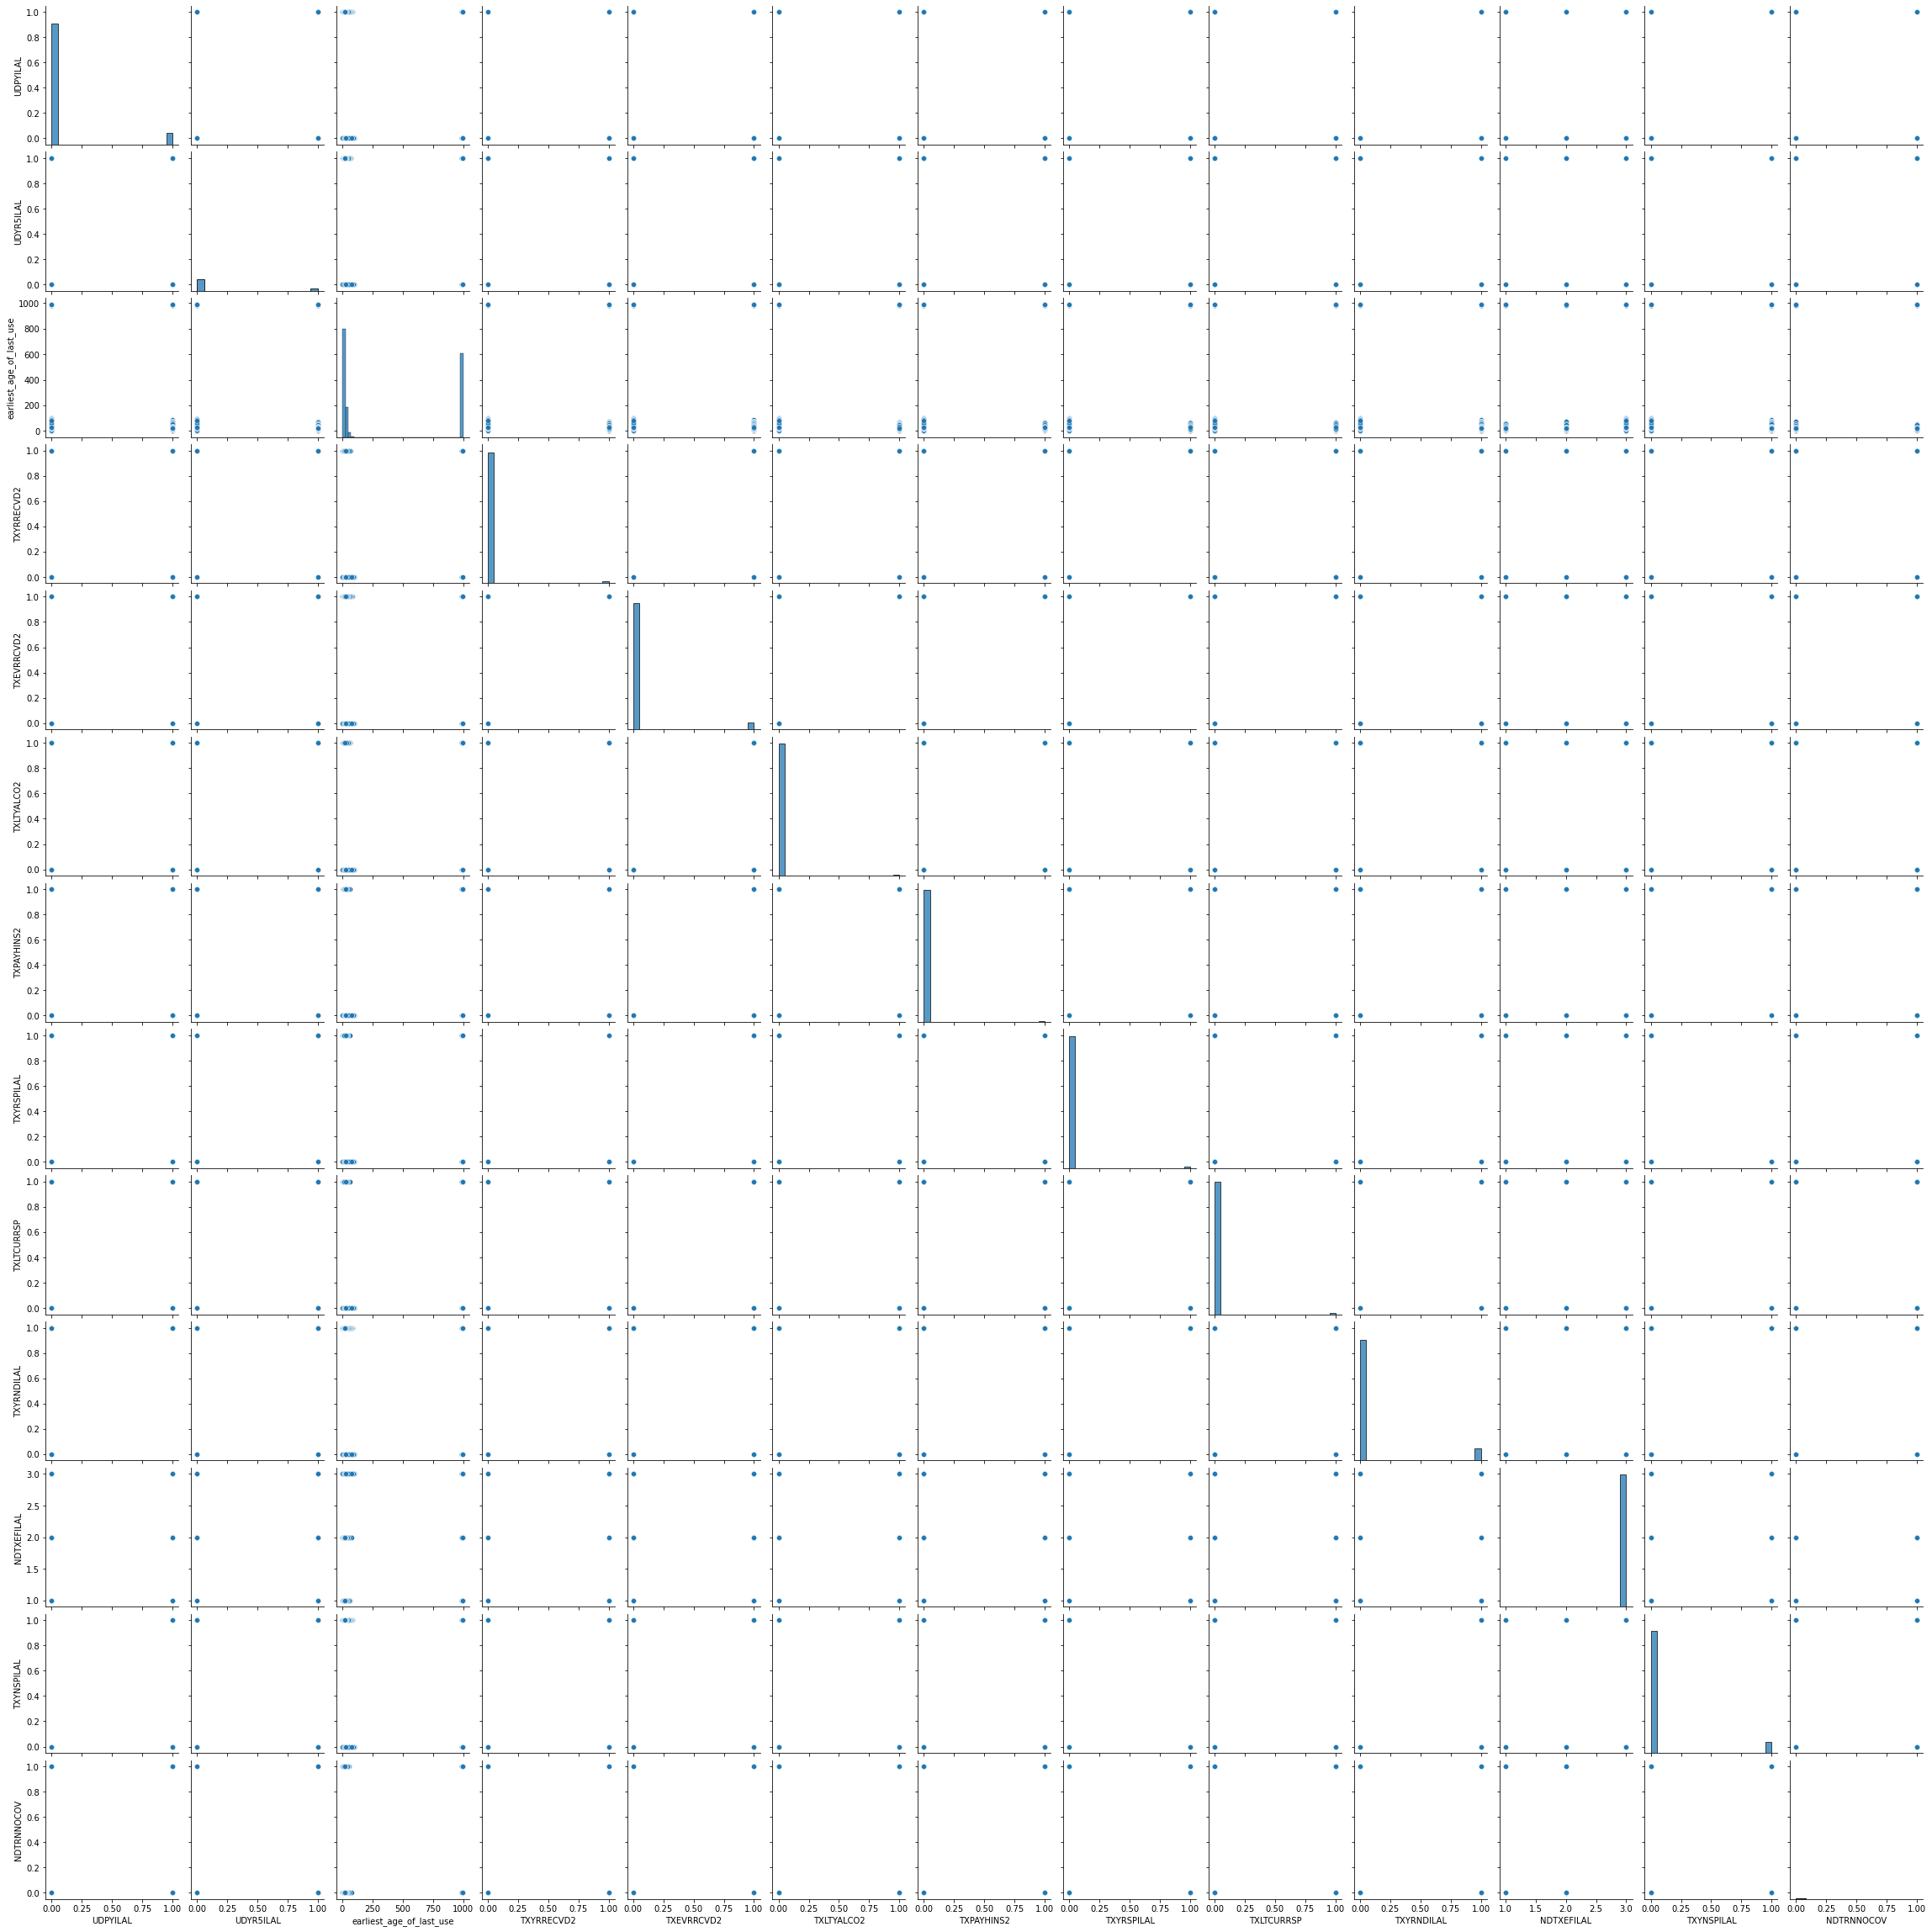

In [ ]:
sns.pairplot(d[d_s1+d_s2])

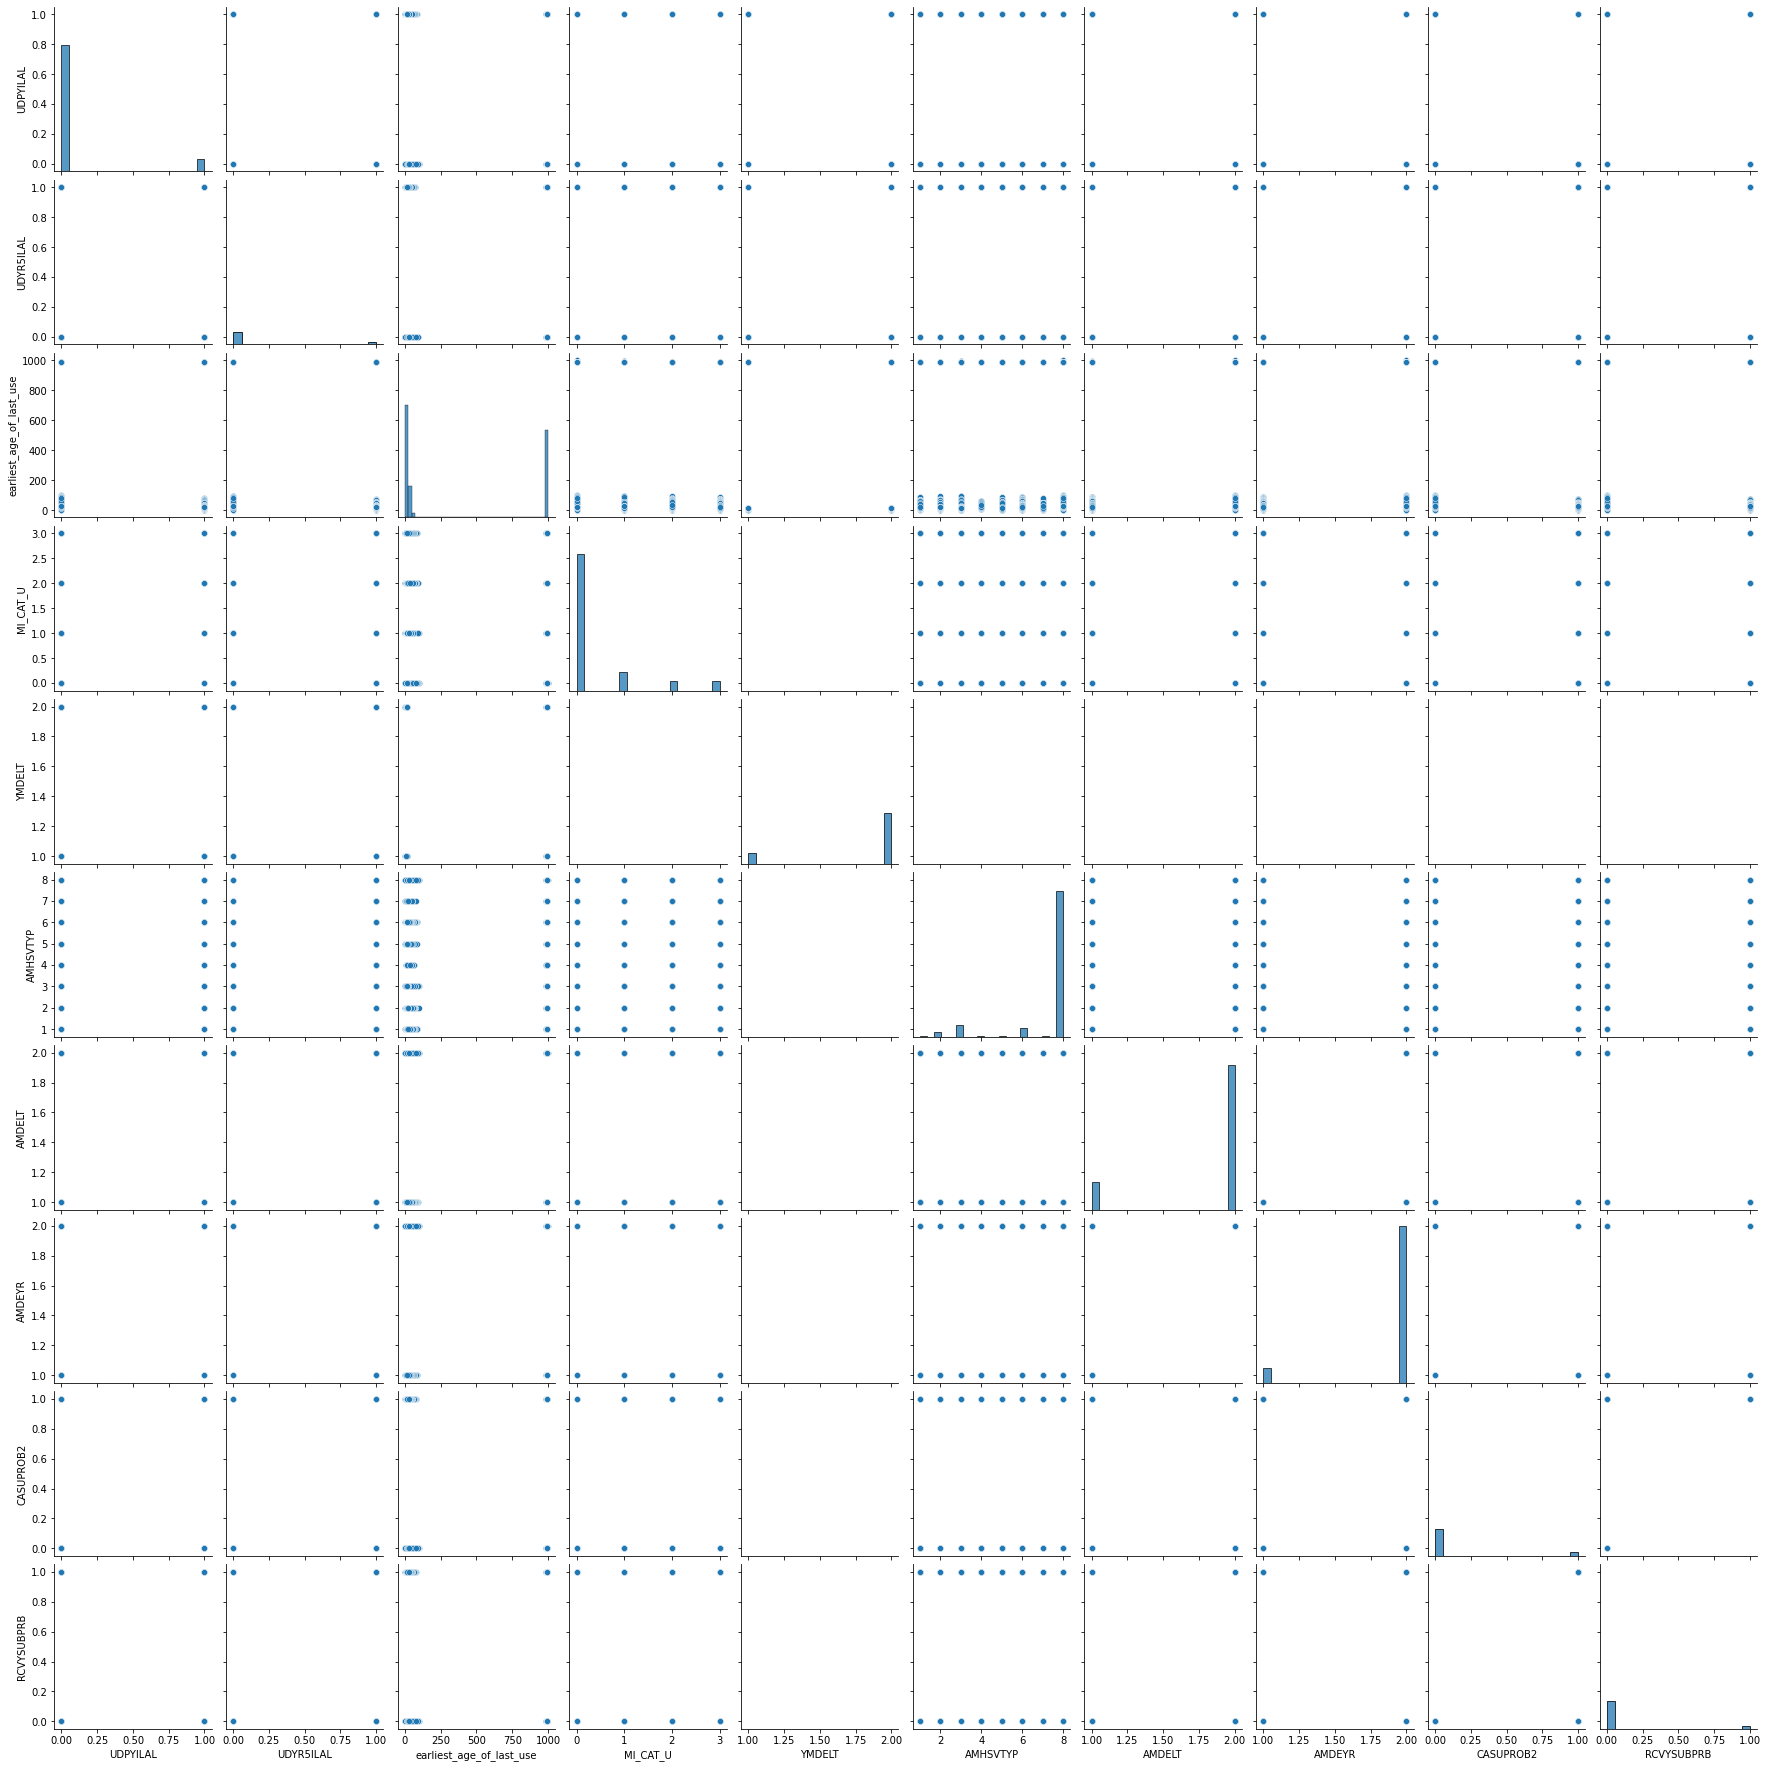

In [ ]:
sns.pairplot(d[d_s1+d_s3])

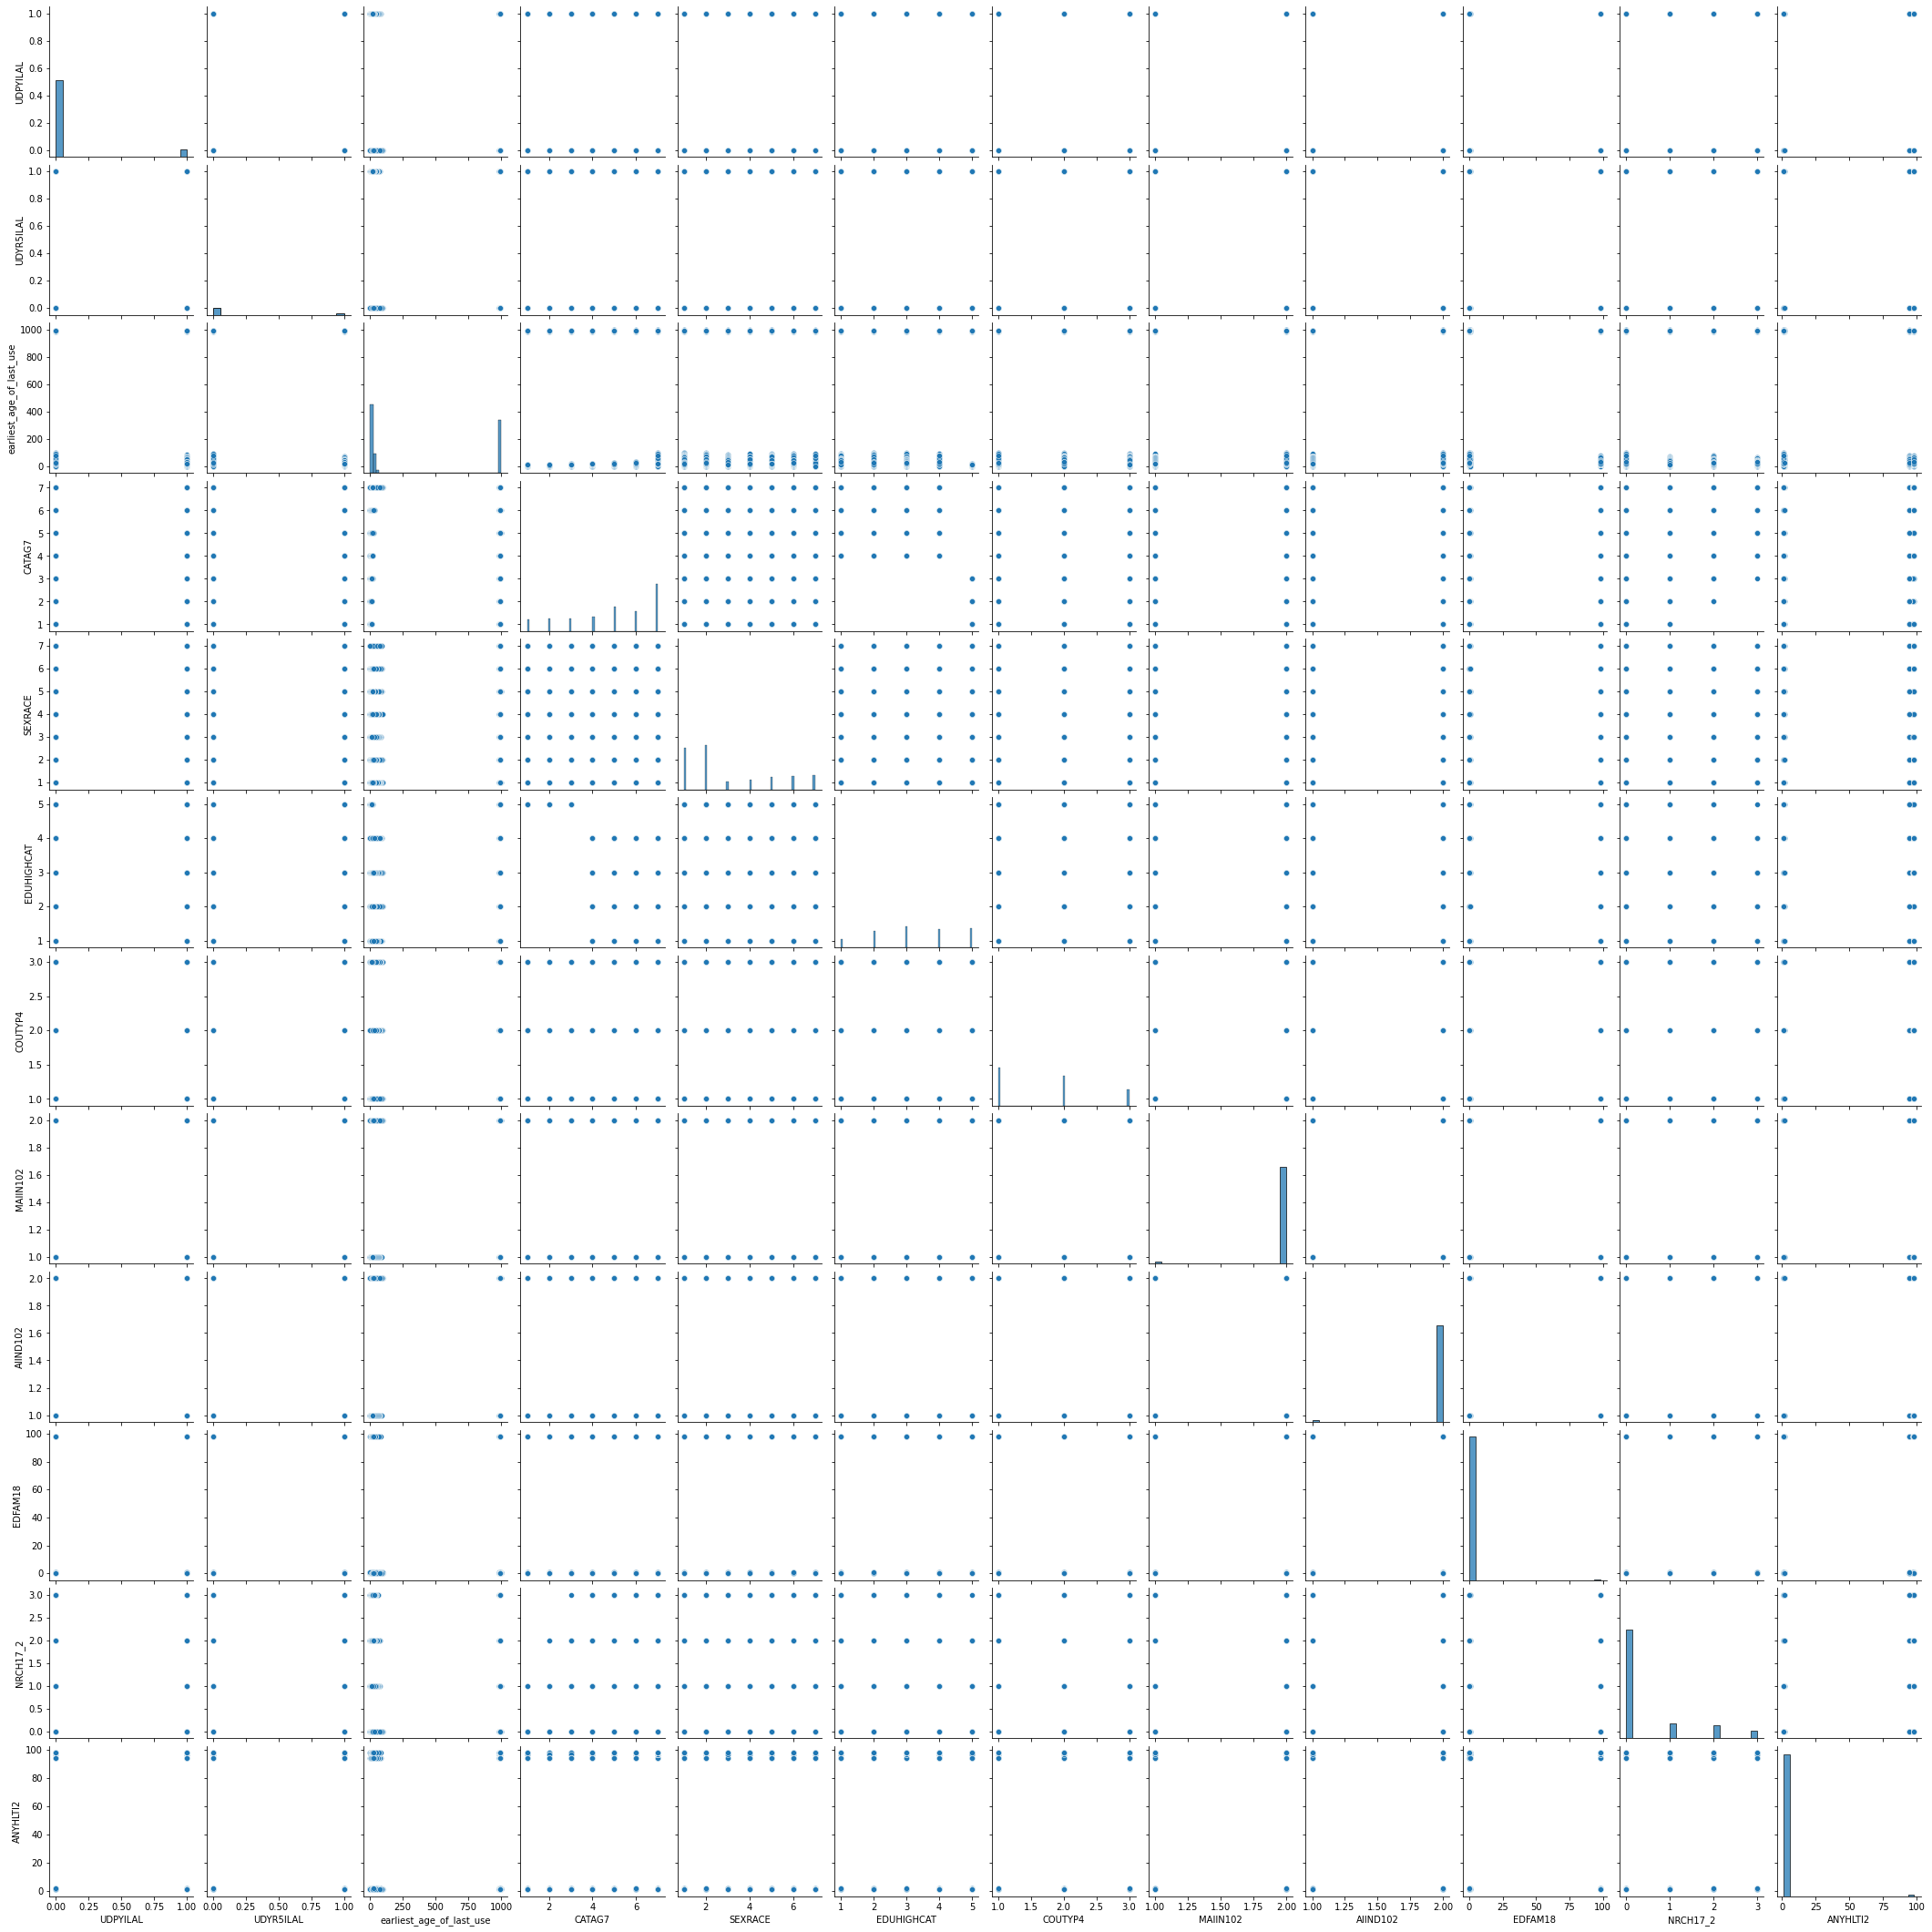

In [ ]:
sns.pairplot(d[d_s1+d_s4])

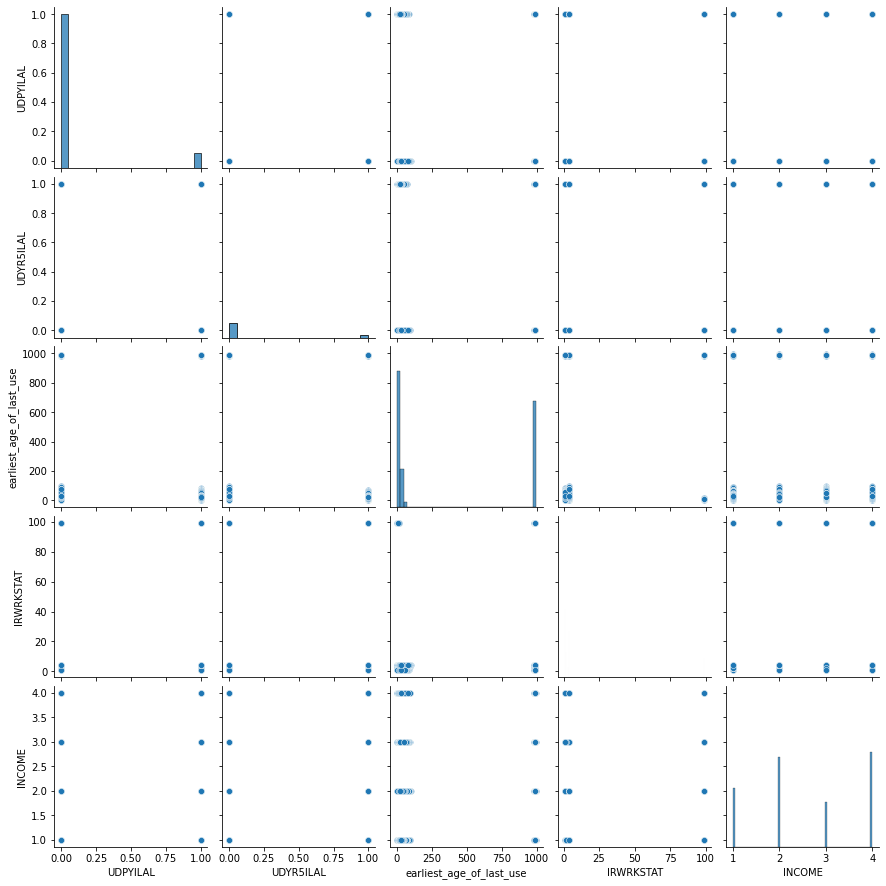

In [ ]:
sns.pairplot(d[d_s1+d_s5])

In [ ]:
sns.pairplot(d[d_s2+d_s3])

NameError: ignored

In [ ]:
sns.pairplot(d[d_s2+d_s4])

In [ ]:
sns.pairplot(d[d_s2+d_s5])

NameError: ignored

In [ ]:
sns.pairplot(d[d_s3+d_s4])

NameError: ignored

In [ ]:
sns.pairplot(d[d_s3+d_s5])

In [ ]:
sns.pairplot(d[d_s4+d_s5])

In [ ]:
sns.barplot(x='year',y='CATAG7', data=d, 
            hue='SEXRACE')
plt.ylabel('Age at the time of the survey')
plt.show() 

In [ ]:
sns.barplot(x='year',y='INCOME', data=d)
plt.ylabel('Income across the years')
plt.show()

In [ ]:
sns.barplot(x='year',y='UDPYILAL', data=d, hue='ANYNEEDL')
plt.ylabel('Any needle ever used')
plt.legend(bbox_to_anchor=(0.4,0.8), loc="upper right")
plt.show() 

In [ ]:
sns.barplot(x='SEXRACE',y='TXYRRECVD2', data=d)
plt.ylabel('Received Treatment at Any Location in the ast Yr') #Received Treatment at Any Location in Past Year
plt.legend()
plt.show() 

In [ ]:
### svk3 for Earliest age of last use only, since the legend is really long, and needed to display it better.
import matplotlib.ticker as ticker

# Only extract the earliest age of use column
dfWIM = d['earliest_age_of_last_use']
ncount = len(dfWIM)

plt.figure(figsize=(12,8))
ax = sns.countplot(x=dfWIM, data=dfWIM)
plt.title('Earliest age of last use')
plt.xlabel('Earliest age of last use')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
#Majority American Indian Area Indicator for Segment
sns.countplot(x="TXYRRECVD2", hue='EDUHIGHCAT', data=d)

### High-level Plots

Text(750, 125, 'Data collection affected by COVID-19 pandemic')

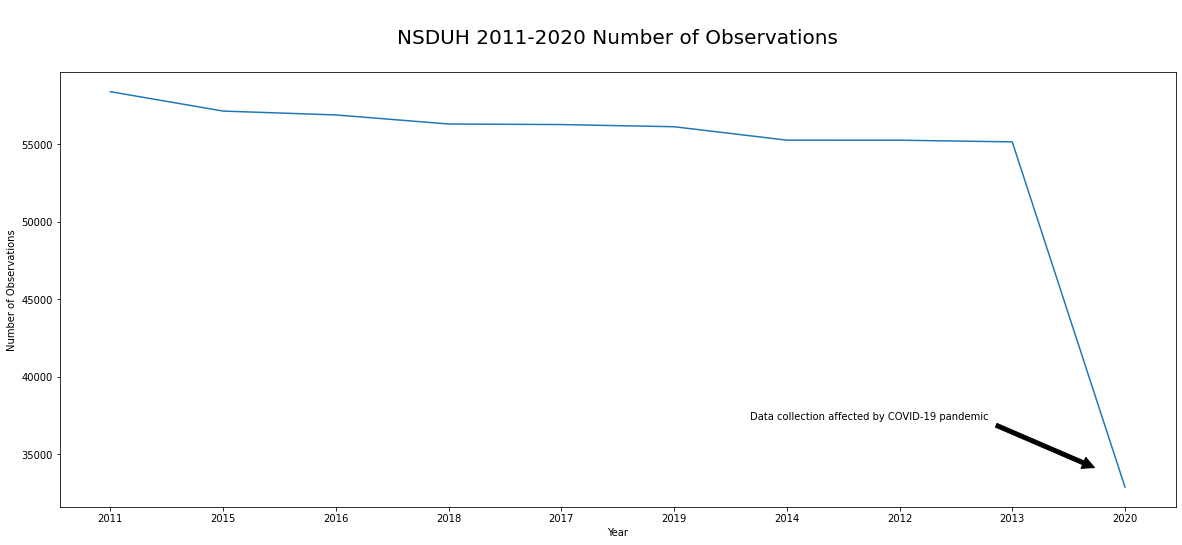

In [ ]:
import seaborn as sns
sns.lineplot(data=d.year.value_counts())
plt.gcf().set_size_inches(20, 8)
plt.title('\nNSDUH 2011-2020 Number of Observations\n', fontsize=20)
plt.xlabel("Year")
plt.ylabel("Number of Observations")
# https://matplotlib.org/stable/tutorials/text/annotations.html
plt.annotate('Data collection affected by COVID-19 pandemic', xy=(1100, 75), xytext=(750, 125), xycoords='figure points',
            arrowprops=dict(facecolor='black', shrink=0.05))

In [ ]:
# additional high-level plots

### Null/Missing Value Analysis

Text(33.0, 0.5, 'Observation')

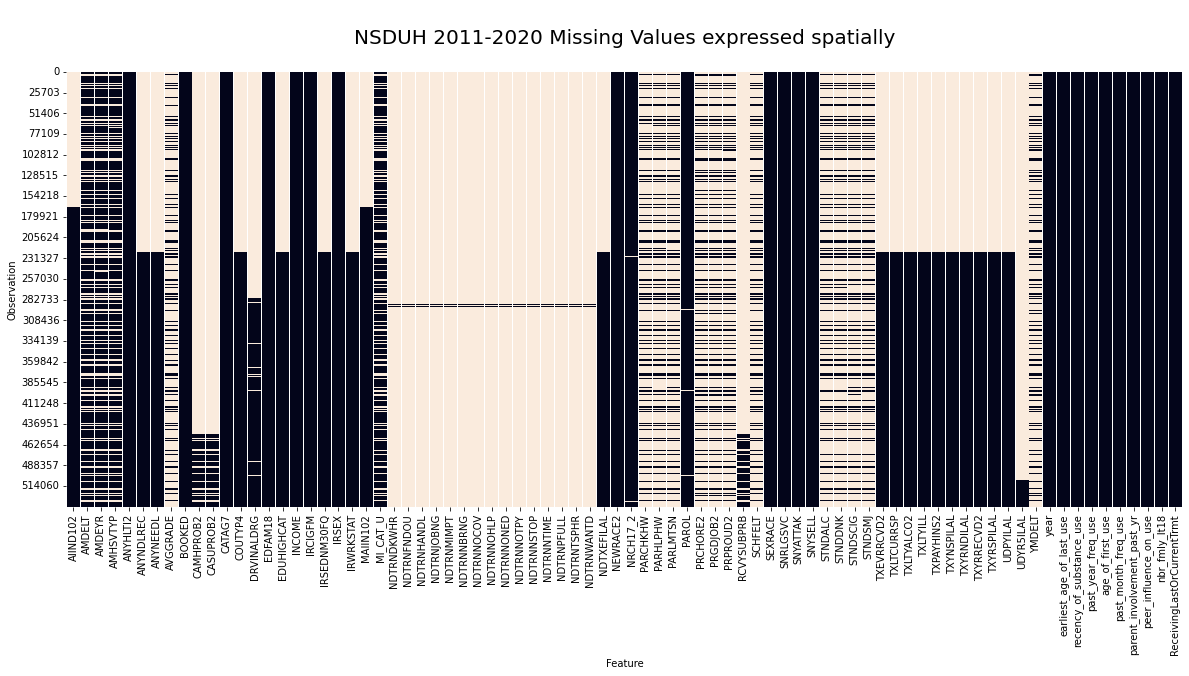

In [ ]:
sns.heatmap(d.isnull(), xticklabels=True, cbar=False)
plt.gcf().set_size_inches(20, 8)
plt.title('\nNSDUH 2011-2020 Missing Values expressed spatially\n', fontsize=20)
plt.xlabel("Feature")
plt.ylabel("Observation")

Text(0.5, 14.09375, 'Feature')

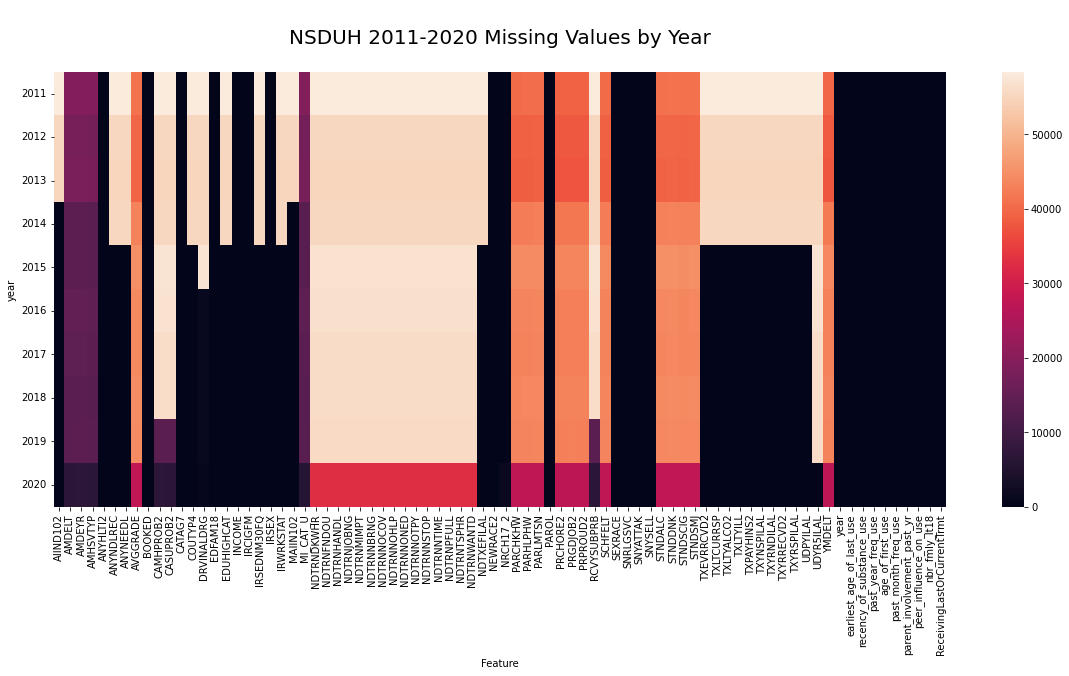

In [ ]:
sns.heatmap(d.groupby('year').apply(lambda x: x.isnull().sum()), xticklabels=True)
plt.gcf().set_size_inches(20, 8)
plt.title('\nNSDUH 2011-2020 Missing Values by Year\n', fontsize=20)
plt.xlabel("Feature")

Text(600, 250, 'NSDUH Redesign')

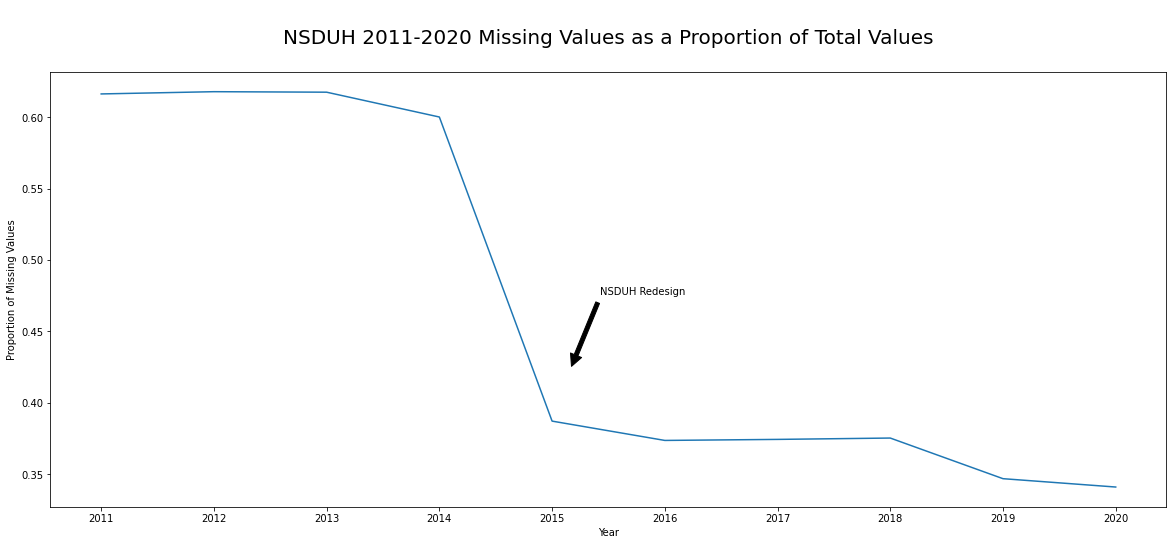

In [ ]:
# missing values as a proportion of total values (year)
sns.lineplot(data=d.groupby('year').apply(lambda x: x.isnull().sum()).sum(axis=1) / d.year.value_counts().apply(lambda x: x * len(d.columns)))
plt.gcf().set_size_inches(20, 8)
plt.title('\nNSDUH 2011-2020 Missing Values as a Proportion of Total Values\n', fontsize=20)
plt.xlabel("Year")
plt.ylabel("Proportion of Missing Values")
# https://matplotlib.org/stable/tutorials/text/annotations.html
plt.annotate('NSDUH Redesign', xy=(570, 175), xytext=(600, 250), xycoords='figure points',
            arrowprops=dict(facecolor='black', shrink=0.05))

In [ ]:
missing_codes = d.isin([91, 991, 9991, 93, 993, 9993, 91, 991, 9991, 93, 993, 9993, 94, 994, 9994, 97, 997, 9997, 98, 998, 9998, 99, 999, 9999, 81, 981, 9981, 83, 983, 9983, 85, 985, 9985, 89, 989, 9989]).sum()[:-8]

Text(0, 0.5, 'Number of Values')

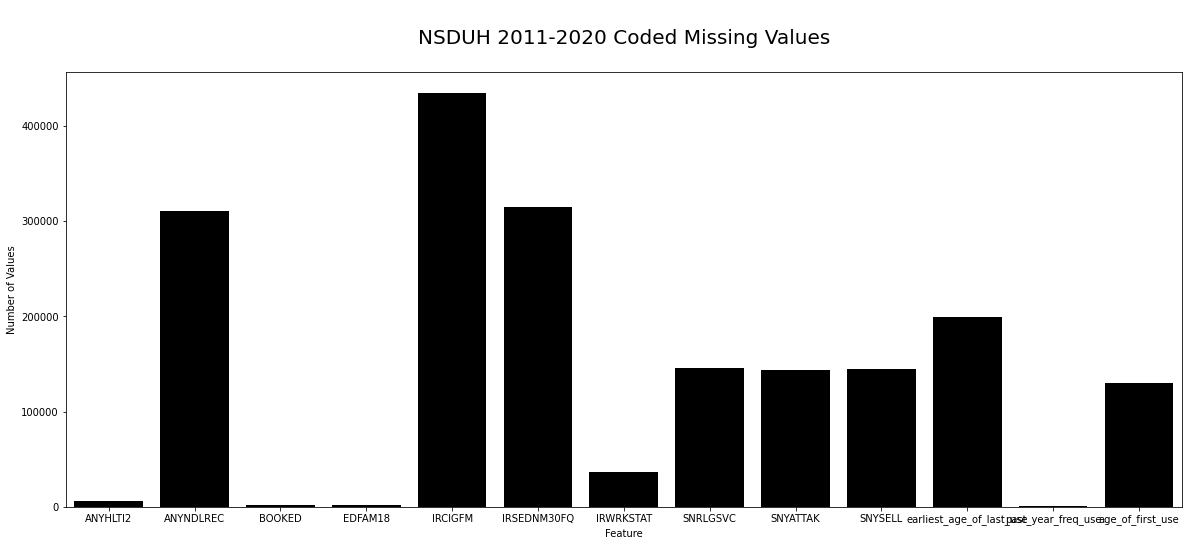

In [ ]:
sns.barplot(x=missing_codes[~(missing_codes==0)].index, y=missing_codes[~(missing_codes==0)].values, color='k')
plt.gcf().set_size_inches(20, 8)
plt.title('\nNSDUH 2011-2020 Coded Missing Values\n', fontsize=20)
plt.xlabel("Feature")
plt.ylabel("Number of Values")

### Summary Statistics Analysis

In [ ]:
summary_stats = d.describe().transpose()
corr = d.corr()

Text(0.5, 1.0, '\nNSDUH 2011-2020 Correlation Plot\n')

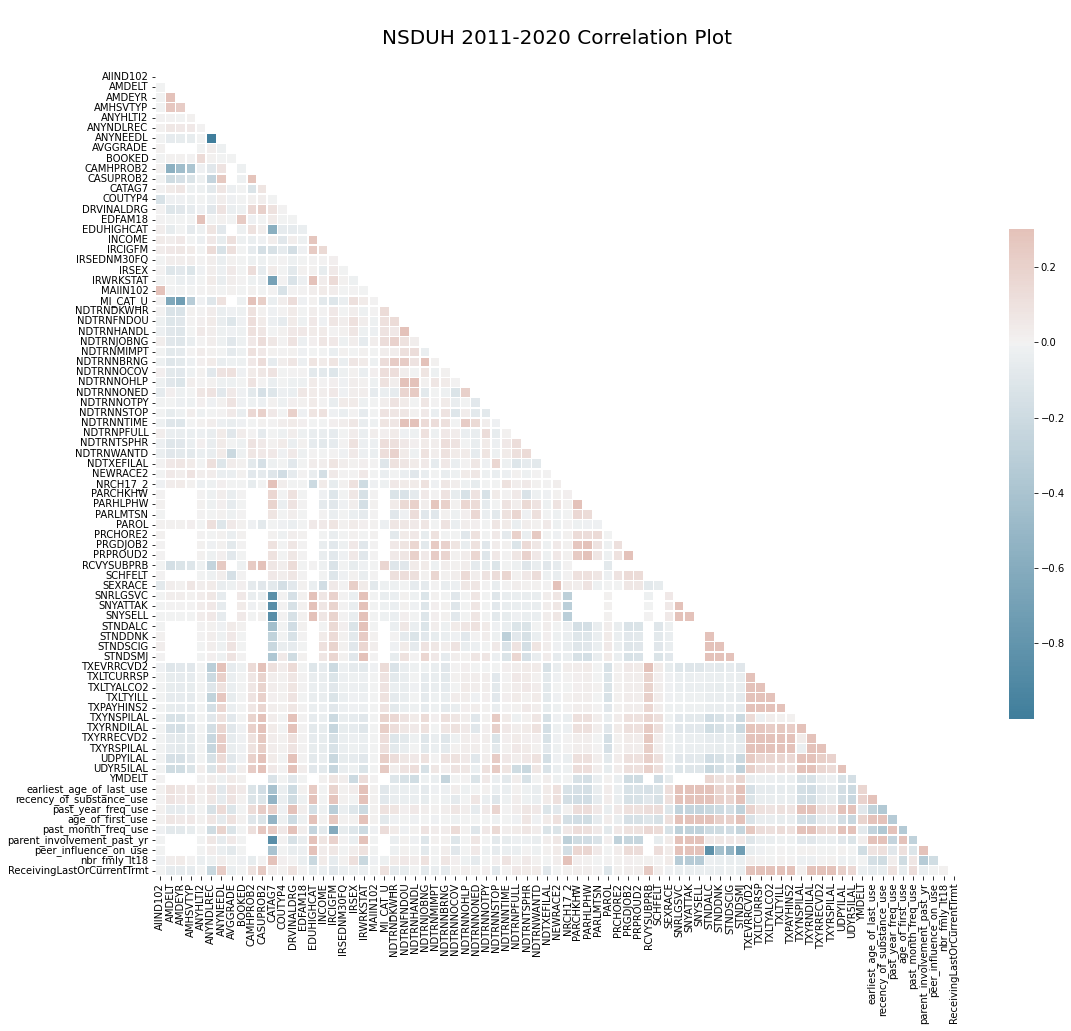

In [ ]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=True)
plt.title('\nNSDUH 2011-2020 Correlation Plot\n', fontsize=20)

In [ ]:
# add additional plots for descriptive statistics, variable distribution, etc

Below needs work

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text major ticklabel objects>)

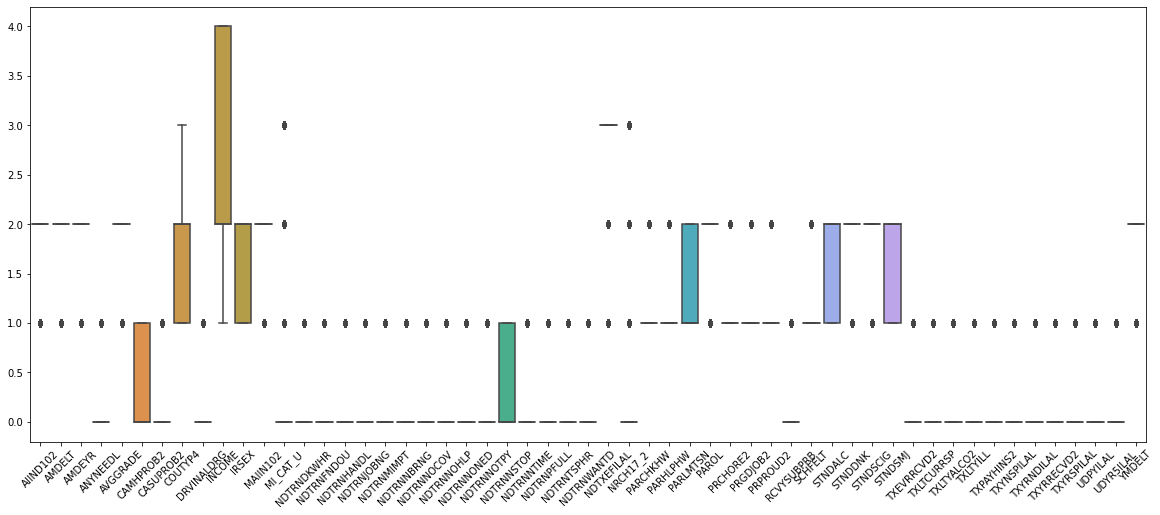

In [ ]:
# subset features to avoid elongated y axis; needs to be a better plot
sns.boxplot(data=d[summary_stats[summary_stats['max'] < 5].index.to_list()])
plt.gcf().set_size_inches(20, 8)
plt.xticks(rotation=45)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

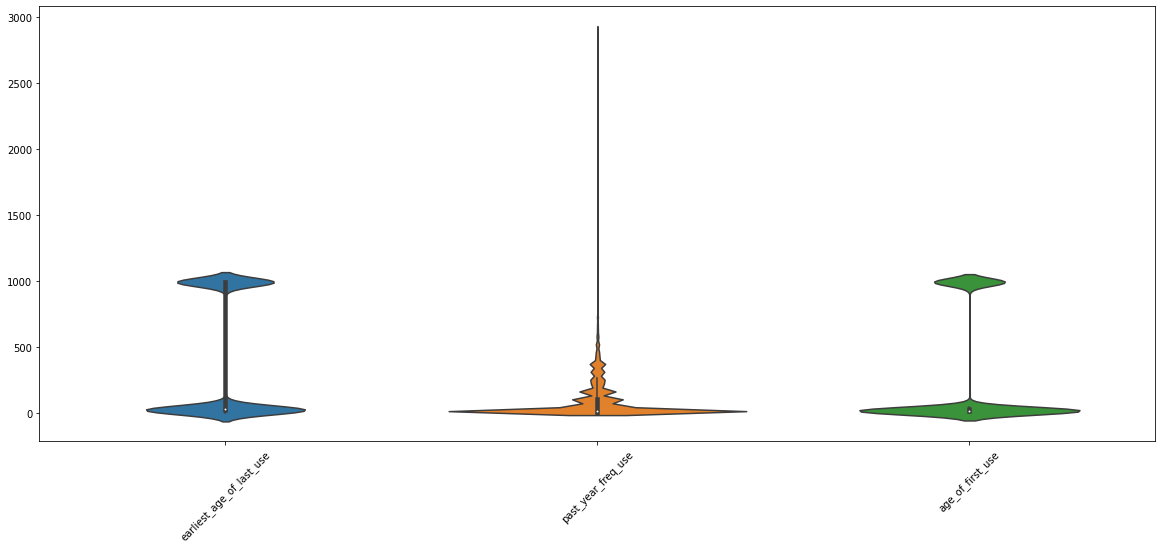

In [ ]:
# subset features to avoid elongated y axis; needs to be a better plot 
sns.violinplot(data=d[['earliest_age_of_last_use', 'past_year_freq_use', 'age_of_first_use']])
plt.gcf().set_size_inches(20, 8)
plt.xticks(rotation=45)

In [ ]:
# way too many features for this to be useful - maybe subset on some interesting ones?
sns.pairplot(d, corner=True)

TypeError: ignored

## Data Cleaning/Imputation

Much of data cleaning was already completed both by NSDUH and by the value_filter in the data loading.  If necessary for our ML methods, we can perform data imputation as per below.

In [ ]:
seed = 42

In [ ]:
def value_filter_2(x):
  if x in [81, 85, 89, 91, 93, 94, 97, 98, 99, 985, 989, 991, 993, 994, 997, 998, 999, 99985, 99989, 99991, 99994, 99997, 99998, 99999]:
    return 0
  else:
    return x

In [ ]:
d = d.applymap(value_filter_2)
d.columns = d.columns.map(str)

In [ ]:
#imp = IterativeImputer(max_iter=10, random_state=seed)
#imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
# https://github.com/scikit-learn/scikit-learn/issues/18186
#imp = KNNImputer(n_neighbors=2, weights="uniform")

In [ ]:
imp.fit(d)

SimpleImputer(fill_value=0, strategy='constant')

In [ ]:
id = imp.transform(d)

In [ ]:
# id = pd.DataFrame(np.round(imp.transform(d)), index=d.index, columns=d.columns)
id = pd.DataFrame(id, index=d.index, columns=d.columns)

In [ ]:
pd.set_option('max_columns', None)

## Additional Data Selection/Reduction/Transformation

In [ ]:
success_index = np.where((id.ReceivingLastOrCurrentTrmt==1) & (id.TXLTYOCOM2 == 2) & (id.past_year_freq_use < id.past_year_freq_use.median()))

In [ ]:
len(success_index[0])

288

In [ ]:
id['successful_treatment'] = np.where((id.ReceivingLastOrCurrentTrmt==1) & (id.TXLTYOCOM2 == 2) & (id.past_year_freq_use < id.past_year_freq_use.median()), 1, 0)

In [ ]:
# scale the data

### PCA

In [ ]:
# scaler = StandardScaler()
scaler = RobustScaler()
# scaler = MinMaxScaler()

In [ ]:
id.drop(['FILEDATE', 'QUESTID2', 'year'], axis=1, inplace=True)
id_scaled = scaler.fit_transform(id)

In [ ]:
# pca
pca = PCA(n_components=10)
pca.fit(id_scaled)

PCA(n_components=10)

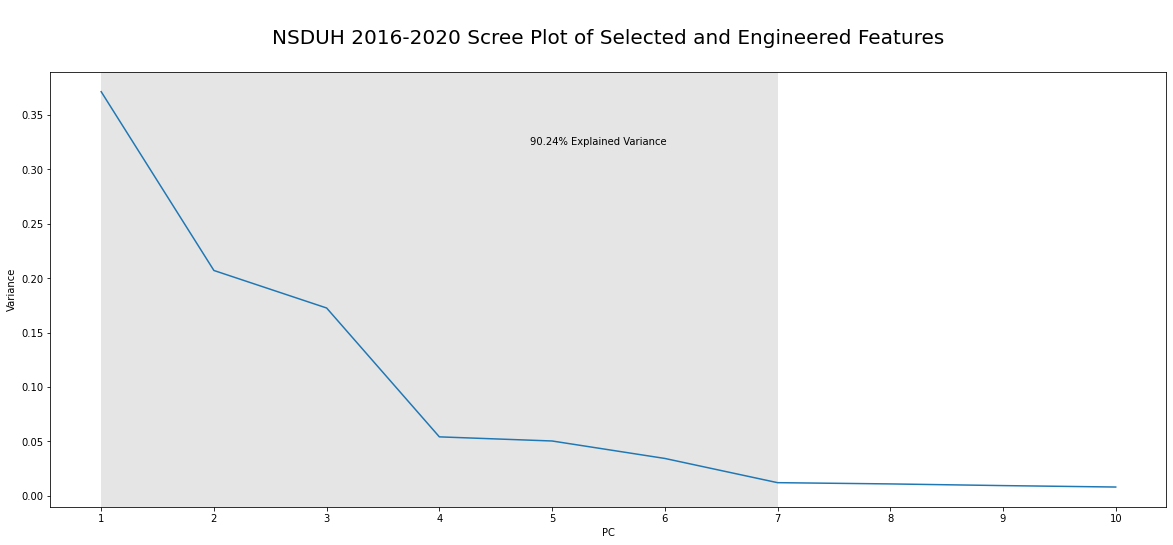

In [ ]:
# https://www.statology.org/scree-plot-python/
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_)
plt.xticks(PC_values)
plt.xlabel('PC')
plt.ylabel('Variance')
plt.gcf().set_size_inches(20, 8)
plt.title('\nNSDUH 2016-2020 Scree Plot of Selected and Engineered Features\n', fontsize=20)
plt.annotate(f'{round(sum(pca.explained_variance_ratio_[0:7]) * 100, 2)}% Explained Variance', xy=(590, 200), xytext=(530, 400), xycoords='figure points')
plt.axvspan(1, 7, color='0.8', alpha=0.5, lw=0)

In [ ]:
round(sum(pca.explained_variance_ratio_[0:7]) * 100, 2)

90.24

In [ ]:
# https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
load = pd.DataFrame(pca.components_.T, columns=[f'PC{x}' for x in range(1,11)], index=id.columns)

### Data sub-selection for queries

In [ ]:
TXLTYMNPL2_dict = {
0: 'Treatment Unknown',
1: 'A hospital overnight as an inpatient',
2: 'A res drug/alcohol rehab facility overnight',
3: 'A drug or alcohol rehab facility as an outpatient',
4: 'A mental health center or facility as outpatient',
5: 'An emergency room',
6: 'A private doctor\'s office',
7: 'A prison or jail',
8: 'Self-help group, Alcoholic/Narcotics Anonymous',
9: 'Some other place',
40: 'Home, family, friends',
41: 'School, college',
42: 'Church/religious/spiritual influence',
44: 'Halfway house/group home',
45: 'Rehab/intervention fac/prgrm, ptnt status unspcfd',
47: 'Communty/city/county/state pgm or facil; unspecfd',
48: 'Counselor, therapist, psychologist, psychiatrist',
49: 'Court-mandated/sponsored program',
64: 'Methadone clinic/program',
65: 'Name of facility/program given',
66: 'Faith-based formal program/facility'
}

In [ ]:
# data sub-selection for individual questions 

In [ ]:
# q1 = id[['year', 'past_month_freq_use', 'age_of_first_use', 'past_year_freq_use', 'recency_of_substance_use', 'earliest_age_of_last_use', 'UDPYILAL', 'UDYR5ILAL', 'TXYRRECVD2', 'TXLTYALCO2', 'NDTXEFILAL', 'TXYNSPILAL', 'MI_CAT_U', 'CATAG7', 'DRVINALDRG']].copy()

In [ ]:
# q2 = id[['past_month_freq_use', 'age_of_first_use', 'past_year_freq_use', 'recency_of_substance_use', 'earliest_age_of_last_use', 'ReceivingLastOrCurrentTrmt, 'MI_CAT_U', 'EDUHIGHCAT', 'COUTYP4', 'MAIIN102', 'AIIND102', 'PAROL', 'BOOKED', 'SNRLGSVC', 'TXPAYHINS2', 'AMHSVTYP', 'NEWRACE2', 'IRSEX', 'UDPYILAL', 'UDYR5ILAL', 'TXYRRECVD2', 'NDTXEFILAL', 'TXYNSPILAL']].copy()

In [ ]:
# q3 = id[['past_month_freq_use', 'past_year_freq_use', 'recency_of_substance_use', 'earliest_age_of_last_use', 'ReceivingLastOrCurrentTrmt', 'TXYRRECVD2', 'TXEVRRCVD2', 'TXLTYILL', 'TXPAYHINS2', 'TXYRSPILAL', 'TXLTCURRSP', 'TXYRNDILAL', 'NDTXEFILAL', 'TXYNSPILAL']].copy()

In [ ]:
# sub-select for questions 4 and 5

In [ ]:
# q4 - linear regression to predict substance use frequency
# q4 = id.drop(['FILEDATE', 'QUESTID2', 'year'], axis=1).astype('int').copy()
q4 = id.astype('int')
q4_X_train_month, q4_X_test_month, q4_y_train_month, q4_y_test_month = train_test_split(
    q4.drop(['past_month_freq_use', 'past_year_freq_use'], axis=1), q4.past_month_freq_use, random_state=seed, test_size=0.2)
q4_X_train_month, q4_X_eval_month, q4_y_train_month, q4_y_eval_month = train_test_split(q4_X_train_month, q4_y_train_month, random_state=seed, test_size=0.2)
q4_X_train_year, q4_X_test_year, q4_y_train_year, q4_y_test_year = train_test_split(
    q4.drop(['past_month_freq_use', 'past_year_freq_use'], axis=1), q4.past_year_freq_use, random_state=seed, test_size=0.2)
q4_X_train_year, q4_X_eval_year, q4_y_train_year, q4_y_eval_year = train_test_split(q4_X_train_year, q4_y_train_year, random_state=seed, test_size=0.2)

In [ ]:
# q5 - recommendation system

In [ ]:
# q5_successful_treatments = id[id.successful_treatment==True].drop(['FILEDATE', 'QUESTID2', 'year'], axis=1).copy()
q5_successful_treatments = id[id.successful_treatment==True].copy()

## Data Modeling/Machine Learning

### Q1

### Q2

### Q3

### Q4

In [ ]:
q4_results = pd.DataFrame()

In [ ]:
# use sklearn's pipeline feature to scale and train data
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
pipe = Pipeline([('scaler', RobustScaler()), ('regressor', LinearRegression())])

Monthly use of substance

In [ ]:
pipe.fit(q4_X_train_month, q4_y_train_month)

Pipeline(steps=[('scaler', RobustScaler()), ('regressor', LinearRegression())])

In [ ]:
q4_results = q4_results.append({'model': 'monthly_MLR', 
                                'R2_train': pipe.score(q4_X_train_month, q4_y_train_month),
                                'R2_eval': pipe.score(q4_X_eval_month, q4_y_eval_month), 
                                'R2_test': pipe.score(q4_X_test_month, q4_y_test_month), 
                                'RMSE_train': mean_squared_error(pipe.predict(q4_X_train_month), q4_y_train_month, squared=False),
                                'RMSE_eval': mean_squared_error(pipe.predict(q4_X_eval_month), q4_y_eval_month, squared=False), 
                                'RMSE_test': mean_squared_error(pipe.predict(q4_X_test_month), q4_y_test_month, squared=False), 
                                'MAE_train': mean_absolute_error(pipe.predict(q4_X_train_month), q4_y_train_month), 
                                'MAE_eval': mean_absolute_error(pipe.predict(q4_X_eval_month), q4_y_eval_month), 
                                'MAE_test': mean_absolute_error(pipe.predict(q4_X_test_month), q4_y_test_month)}, 
                               ignore_index=True)

Yearly use of substance

In [ ]:
pipe.fit(q4_X_train_year, q4_y_train_year)

Pipeline(steps=[('scaler', RobustScaler()), ('regressor', LinearRegression())])

In [ ]:
q4_results = q4_results.append({'model': 'yearly_MLR', 
                                'R2_train': pipe.score(q4_X_train_year, q4_y_train_year),
                                'R2_eval': pipe.score(q4_X_eval_year, q4_y_eval_year), 
                                'R2_test': pipe.score(q4_X_test_year, q4_y_test_year), 
                                'RMSE_train': mean_squared_error(pipe.predict(q4_X_train_year), q4_y_train_year, squared=False),
                                'RMSE_eval': mean_squared_error(pipe.predict(q4_X_eval_year), q4_y_eval_year, squared=False), 
                                'RMSE_test': mean_squared_error(pipe.predict(q4_X_test_year), q4_y_test_year, squared=False), 
                                'MAE_train': mean_absolute_error(pipe.predict(q4_X_train_year), q4_y_train_year), 
                                'MAE_eval': mean_absolute_error(pipe.predict(q4_X_eval_year), q4_y_eval_year), 
                                'MAE_test': mean_absolute_error(pipe.predict(q4_X_test_year), q4_y_test_year)}, 
                               ignore_index=True)

In [ ]:
q4_results

model  R2_train   R2_eval   R2_test  RMSE_train   RMSE_eval  \
0  monthly_MLR  0.360067  0.355924  0.354435   14.742347   14.743758   
1   yearly_MLR  0.374034  0.365273  0.373237  103.063450  102.723994   

    RMSE_test  MAE_train   MAE_eval   MAE_test  
0   14.776496  10.042750  10.009242  10.026683  
1  103.210531  68.184945  68.287364  68.434196

Let's try a more advanced regressor, CatBoost

In [ ]:
# Subset of columns that are easily one-hot-encodeable
cat_columns = [x for x in range(len(q4_X_train_month.columns)) if len(q4_X_train_month[q4_X_train_month.columns[x]].unique()) < 25]

In [ ]:
# https://catboost.ai/en/docs/concepts/python-quickstart#regression

train_pool = Pool(q4_X_train_month, q4_y_train_month, cat_features=cat_columns)
test_pool = Pool(q4_X_test_month, q4_y_test_month, cat_features=cat_columns) 
eval_pool = Pool(q4_X_eval_month, q4_y_eval_month, cat_features=cat_columns)

In [ ]:
model = CatBoostRegressor(iterations=500, depth=10, learning_rate=1e-1, loss_function='RMSE', use_best_model=True, early_stopping_rounds=3)

In [ ]:
model.fit(train_pool, eval_set=eval_pool)

0:	learn: 17.7203710	test: 17.6677791	best: 17.6677791 (0)	total: 1.45s	remaining: 12m 1s
1:	learn: 17.1082000	test: 17.0640433	best: 17.0640433 (1)	total: 2.88s	remaining: 11m 57s
2:	learn: 16.5699231	test: 16.5316299	best: 16.5316299 (2)	total: 4.3s	remaining: 11m 52s
3:	learn: 16.1162640	test: 16.0874665	best: 16.0874665 (3)	total: 5.58s	remaining: 11m 32s
4:	learn: 15.7291525	test: 15.7065924	best: 15.7065924 (4)	total: 6.94s	remaining: 11m 27s
5:	learn: 15.4034163	test: 15.3880968	best: 15.3880968 (5)	total: 8.31s	remaining: 11m 23s
6:	learn: 15.1253957	test: 15.1219531	best: 15.1219531 (6)	total: 9.63s	remaining: 11m 18s
7:	learn: 14.8922384	test: 14.9041640	best: 14.9041640 (7)	total: 10.9s	remaining: 11m 11s
8:	learn: 14.6937094	test: 14.7186696	best: 14.7186696 (8)	total: 12.2s	remaining: 11m 5s
9:	learn: 14.5279691	test: 14.5622488	best: 14.5622488 (9)	total: 13.4s	remaining: 10m 58s
10:	learn: 14.3860856	test: 14.4236364	best: 14.4236364 (10)	total: 14.6s	remaining: 10m 49s


In [ ]:
q4_results = q4_results.append({'model': 'monthly_CatBoost', 
                                'R2_train': model.score(train_pool),
                                'R2_eval': model.score(eval_pool), 
                                'R2_test': model.score(test_pool), 
                                'RMSE_train': model.best_score_['learn']['RMSE'],
                                'RMSE_eval': model.best_score_['validation']['RMSE'], 
                                'RMSE_test': mean_squared_error(model.predict(test_pool), q4_y_test_month, squared=False), 
                                'MAE_train': mean_absolute_error(model.predict(train_pool), q4_y_train_month), 
                                'MAE_eval': mean_absolute_error(model.predict(eval_pool), q4_y_eval_month), 
                                'MAE_test': mean_absolute_error(model.predict(test_pool), q4_y_test_month)}, 
                               ignore_index=True)

In [ ]:
q4_results

model  R2_train   R2_eval   R2_test  RMSE_train   RMSE_eval  \
0       monthly_MLR  0.360067  0.355924  0.354435   14.742347   14.743758   
1        yearly_MLR  0.374034  0.365273  0.373237  103.063450  102.723994   
2  monthly_CatBoost  0.502702  0.463669  0.463650   12.972389   13.454150   

    RMSE_test  MAE_train   MAE_eval   MAE_test  
0   14.776496  10.042750  10.009242  10.026683  
1  103.210531  68.184945  68.287364  68.434196  
2   13.468697   7.666156   7.838755   7.854987

Now let's try for the year

In [ ]:
year_train_pool = Pool(q4_X_train_year, q4_y_train_year, cat_features=cat_columns)
year_test_pool = Pool(q4_X_test_year, q4_y_test_year, cat_features=cat_columns) 
year_eval_pool = Pool(q4_X_eval_year, q4_y_eval_year, cat_features=cat_columns)

year_model = CatBoostRegressor(iterations=500, depth=10, learning_rate=1e-1, loss_function='RMSE', use_best_model=True, early_stopping_rounds=3)

In [ ]:
year_model.fit(year_train_pool, eval_set=year_eval_pool)

0:	learn: 125.2385235	test: 124.0293932	best: 124.0293932 (0)	total: 1.35s	remaining: 11m 16s
1:	learn: 120.9235350	test: 119.8589622	best: 119.8589622 (1)	total: 2.64s	remaining: 10m 57s
2:	learn: 117.2735079	test: 116.3557452	best: 116.3557452 (2)	total: 3.77s	remaining: 10m 25s
3:	learn: 114.1838973	test: 113.3452596	best: 113.3452596 (3)	total: 5.11s	remaining: 10m 33s
4:	learn: 111.6030428	test: 110.8408682	best: 110.8408682 (4)	total: 6.34s	remaining: 10m 28s
5:	learn: 109.3484001	test: 108.7002345	best: 108.7002345 (5)	total: 7.55s	remaining: 10m 21s
6:	learn: 107.4963640	test: 106.9490924	best: 106.9490924 (6)	total: 8.74s	remaining: 10m 15s
7:	learn: 105.8962620	test: 105.4673212	best: 105.4673212 (7)	total: 10s	remaining: 10m 15s
8:	learn: 104.6103591	test: 104.2523850	best: 104.2523850 (8)	total: 11.3s	remaining: 10m 18s
9:	learn: 103.4394740	test: 103.1673080	best: 103.1673080 (9)	total: 12.6s	remaining: 10m 15s
10:	learn: 102.4849609	test: 102.2762666	best: 102.2762666 (10

In [ ]:
q4_results = q4_results.append({'model': 'yearly_CatBoost', 
                                'R2_train': year_model.score(year_train_pool),
                                'R2_eval': year_model.score(year_eval_pool), 
                                'R2_test': year_model.score(year_test_pool), 
                                'RMSE_train': year_model.best_score_['learn']['RMSE'],
                                'RMSE_eval': year_model.best_score_['validation']['RMSE'], 
                                'RMSE_test': mean_squared_error(year_model.predict(year_test_pool), q4_y_test_year, squared=False), 
                                'MAE_train': mean_absolute_error(year_model.predict(year_train_pool), q4_y_train_year), 
                                'MAE_eval': mean_absolute_error(year_model.predict(year_eval_pool), q4_y_eval_year), 
                                'MAE_test': mean_absolute_error(year_model.predict(year_test_pool), q4_y_test_year)}, 
                               ignore_index=True)

In [ ]:
q4_results.round(2)

model  R2_train  R2_eval  R2_test  RMSE_train  RMSE_eval  \
0       monthly_MLR      0.36     0.36     0.35       14.74      14.74   
1        yearly_MLR      0.37     0.37     0.37      103.06     102.72   
2  monthly_CatBoost      0.50     0.46     0.46       12.97      13.45   
3   yearly_CatBoost      0.49     0.44     0.45       92.96      96.10   

   RMSE_test  MAE_train  MAE_eval  MAE_test  
0      14.78      10.04     10.01     10.03  
1     103.21      68.18     68.29     68.43  
2      13.47       7.67      7.84      7.85  
3      96.43      55.80     57.17     57.31

feature importance

In [ ]:
shap_values = model.get_feature_importance(test_pool, type="ShapValues")

In [ ]:
# https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed
shap_values = shap_values[:,:-1]
expected_value = shap_values[0,-1]

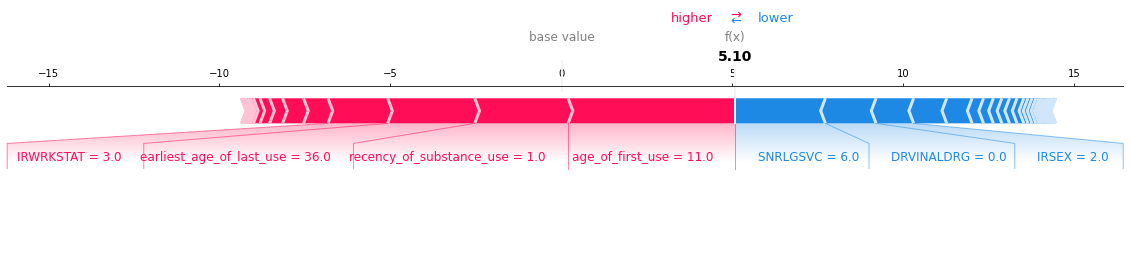

In [ ]:
shap.initjs() 
shap.force_plot(expected_value, shap_values[1500,:], q4_X_test_month.iloc[1500,:], matplotlib=True)

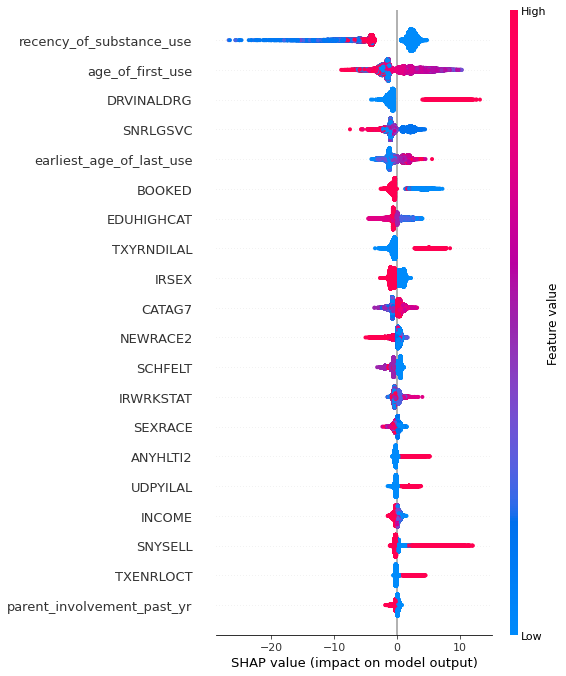

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, q4_X_test_month)

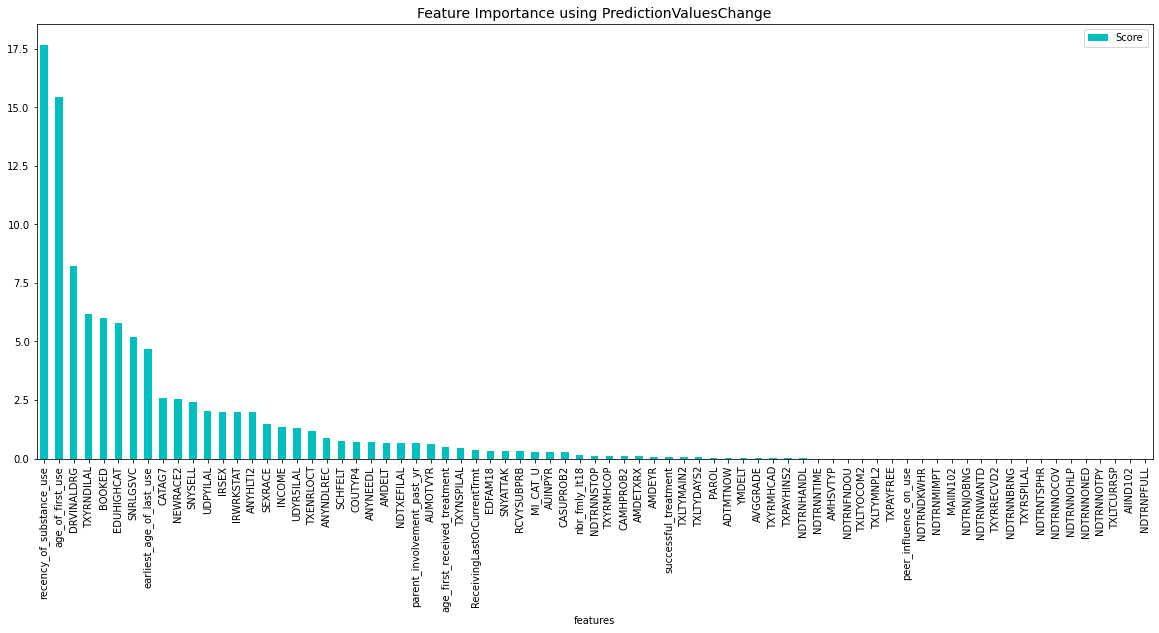

In [ ]:
# learned a lot from the below link to do this, need to cite it in the paper
# https://gist.github.com/aswalin/595ac73f91c6268f9ca449a4ee05dee1#file-catboost-ipynb
fi = model.get_feature_importance(test_pool, type='PredictionValuesChange')

feature_score = pd.DataFrame(list(zip(q4_X_test_month.dtypes.index, fi )), columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

# plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('PredictionValuesChange'), fontsize = 14)
ax.set_xlabel("features")
plt.gcf().set_size_inches(20, 8)
plt.show()

### Q5

#### K-Means

HP search for best n clusters, maximize silhouette, get to elbow of inertia

In [ ]:
n_clusters = list(range(3,21))
silhouettes = dict()
inertias = dict()

for x in n_clusters:
  cluster = KMeans(n_clusters=x, random_state=seed)
  labels = cluster.fit_predict(q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1))
  silhouettes[x] = silhouette_score(q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1), labels)
  inertias[x] = cluster.inertia_

In [ ]:
silhouettes

{3: 0.41174739019273043,
 4: 0.4197843104451571,
 5: 0.4078718639545096,
 6: 0.43379211839749005,
 7: 0.42316639500190356,
 8: 0.35814617646811453,
 9: 0.32312708758754227,
 10: 0.3105519647187012,
 11: 0.2846405196310528,
 12: 0.2341522185026954,
 13: 0.23360729014883733,
 14: 0.2426749458377367,
 15: 0.22088266383048885,
 16: 0.2409193880266425,
 17: 0.227893846517231,
 18: 0.21732366677537715,
 19: 0.206157721952814,
 20: 0.1896257617052641}

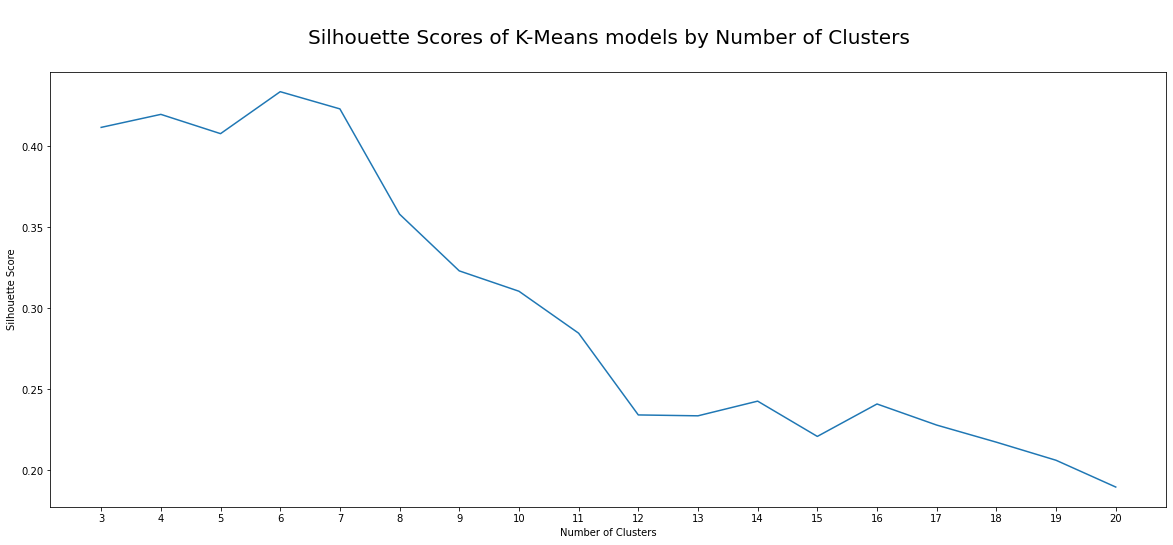

In [ ]:
plt.plot(*zip(*sorted(silhouettes.items())))
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.gcf().set_size_inches(20, 8)
plt.title('\nSilhouette Scores of K-Means models by Number of Clusters\n', fontsize=20)
plt.show()

In [ ]:
inertias

{3: 71736.62251570981,
 4: 60494.66193181819,
 5: 51109.91031494848,
 6: 42571.72340222973,
 7: 37256.67900389508,
 8: 34289.52327128918,
 9: 31792.48930315421,
 10: 30071.013404191086,
 11: 29102.440384597165,
 12: 27570.947316647696,
 13: 26608.763709060633,
 14: 26030.76044885587,
 15: 25108.121988680905,
 16: 24492.179212962965,
 17: 23367.716616919373,
 18: 22762.134274254855,
 19: 22427.653811020446,
 20: 21741.164058334743}

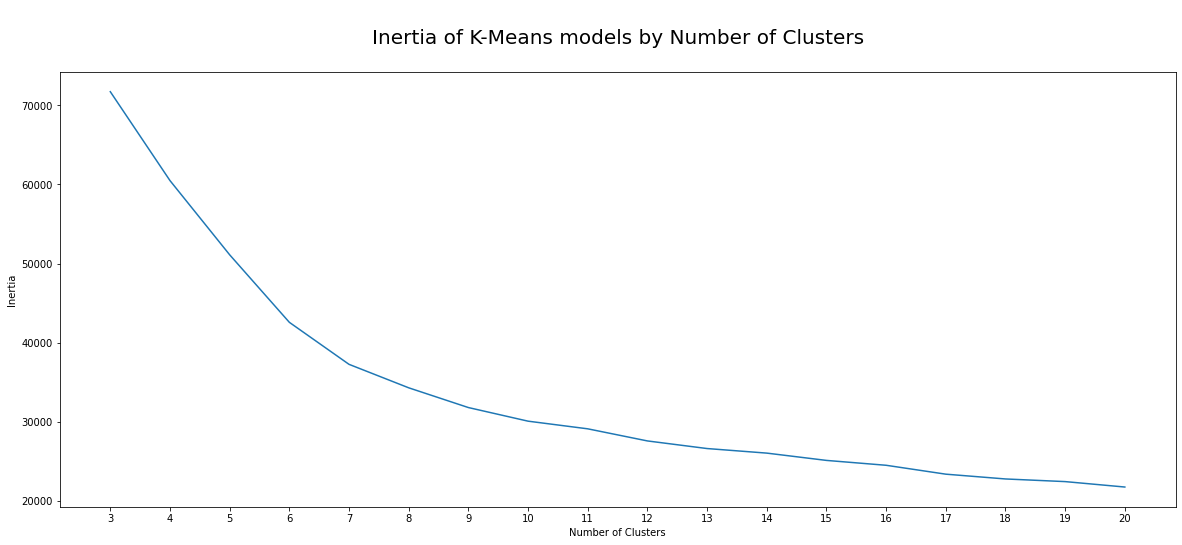

In [ ]:
plt.plot(*zip(*sorted(inertias.items())))
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.gcf().set_size_inches(20, 8)
plt.title('\nInertia of K-Means models by Number of Clusters\n', fontsize=20)
plt.show()

In [ ]:
cluster = KMeans(n_clusters=max(silhouettes, key=silhouettes.get), random_state=seed)
labels = cluster.fit_predict(q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1))

In [ ]:
transformed = cluster.transform(q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1))

#### Inference

join labels and distance to new dataframe

In [ ]:
q5_k_means = q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1).copy()
q5_k_means['cluster_label'] = labels
q5_k_means['cluster_space'] = transformed.tolist()

perform inference

In [ ]:
# choose a random data point in our dataset that has a high substance use
# random_response = id[(id.past_month_freq_use > id.past_month_freq_use.median()*2) & 
#    (id.ReceivingLastOrCurrentTrmt == 0)].drop(['FILEDATE', 'QUESTID2', 'year', 'ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1).sample(1).astype('int').copy()

random_response = id[(id.past_month_freq_use > id.past_month_freq_use.median()*2) & 
   (id.ReceivingLastOrCurrentTrmt == 0)].drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1).sample(1).astype('int').copy()

In [ ]:
predicted_cluster = cluster.predict(random_response)

In [ ]:
predicted_cluster[0]

2

In [ ]:
# predicted_cluster = cluster.predict(id[(id.past_month_freq_use > id.past_month_freq_use.median()*5) & 
#    (id.ReceivingLastOrCurrentTrmt == 0)].drop(['FILEDATE', 'QUESTID2', 'year', 'ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1))

predicted_cluster = cluster.predict(id[(id.past_month_freq_use > id.past_month_freq_use.median()*5) & 
   (id.ReceivingLastOrCurrentTrmt == 0)].drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1))

pd.value_counts(predicted_cluster)

3    47259
2    14394
5     3415
4      145
dtype: int64

In [ ]:
# return all cluster members
# q5_k_means[q5_k_means.cluster_label == predicted_cluster[0]]

In [ ]:
# calculate their Manhattan distance to our new observation
new_point = cluster.transform(random_response)

In [ ]:
new_point

array([[261.33861998, 261.06714866, 258.20982002, 258.422579  ,
        261.85369632, 263.68598486]])

In [ ]:
distances = q5_k_means[q5_k_means.cluster_label == predicted_cluster[0]].cluster_space.apply(
    lambda x: manhattan_distances(np.array(x).reshape(1, -1), new_point)[0][0]
)

In [ ]:
distances.index.map(lambda x: TXLTYMNPL2_dict[q5_successful_treatments.loc[x].TXLTYMNPL2]).value_counts()

A drug or alcohol rehab facility as an outpatient    4
Treatment Unknown                                    3
A private doctor's office                            2
An emergency room                                    2
Some other place                                     2
A res drug/alcohol rehab facility overnight          2
A hospital overnight as an inpatient                 2
Self-help group, Alcoholic/Narcotics Anonymous       2
A mental health center or facility as outpatient     2
Name of facility/program given                       1
dtype: int64

In [ ]:
# closest in distance
TXLTYMNPL2_dict[q5_successful_treatments.loc[distances.idxmin()].TXLTYMNPL2]

'A res drug/alcohol rehab facility overnight'

In [ ]:
# closest mean distance in cluster
TXLTYMNPL2_dict[distances.to_frame().join(q5_successful_treatments.TXLTYMNPL2).groupby('TXLTYMNPL2').mean().idxmin()[0]]

'A res drug/alcohol rehab facility overnight'

#### Memory-based model (Cosine Similarity)

try a fully memory based method

In [ ]:
closest_similarity = q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1).apply(lambda x: cosine_similarity(np.array(x).reshape(1, -1), random_response)[0][0], axis=1).idxmax()

In [ ]:
TXLTYMNPL2_dict[q5_successful_treatments.loc[closest_similarity].TXLTYMNPL2]

'Self-help group, Alcoholic/Narcotics Anonymous'

#### DBSCAN

In [ ]:
dbscan_cluster = DBSCAN(min_samples=5, eps=10)
dbscan_cluster.fit(q5_successful_treatments)

DBSCAN(eps=10)

In [ ]:
pd.value_counts(dbscan_cluster.labels_)

-1    140
 0     73
 1     57
 3     11
 2      7
dtype: int64

In [ ]:
silhouette_score(q5_successful_treatments, dbscan_cluster.labels_)

0.11397643444574745

Silhouette score is very low, DBSCAN does not seem great for this problem, but can continue to tweak HPs

#### Agglomerative Clustering

In [ ]:
ag_cluster = AgglomerativeClustering(n_clusters=10)

In [ ]:
ag_cluster.fit(q5_successful_treatments)

AgglomerativeClustering(n_clusters=10)

In [ ]:
pd.value_counts(ag_cluster.labels_)

0    86
9    67
3    39
5    21
1    18
4    15
2    14
6    10
8     9
7     9
dtype: int64

In [ ]:
silhouette_score(q5_successful_treatments, ag_cluster.labels_)

0.40993714706455886

In [ ]:
ag_silhouettes = dict()

for x in n_clusters:
  ag_cluster = AgglomerativeClustering(n_clusters=x)
  ag_labels = ag_cluster.fit_predict(q5_successful_treatments)
  ag_silhouettes[x] = silhouette_score(q5_successful_treatments, ag_labels)

In [ ]:
ag_silhouettes

{3: 0.3861508892949421,
 4: 0.37804830726472277,
 5: 0.37989772777789915,
 6: 0.3767356268288393,
 7: 0.3854423990718069,
 8: 0.40626243808569085,
 9: 0.4136939452212396,
 10: 0.40993714706455886,
 11: 0.3463375736738151,
 12: 0.34554357614568343,
 13: 0.3398665158737786,
 14: 0.32987588623982034,
 15: 0.3229249647759818,
 16: 0.32061328089479213,
 17: 0.28430931814826266,
 18: 0.28081625673978444,
 19: 0.2637279959903363,
 20: 0.263755287013258}

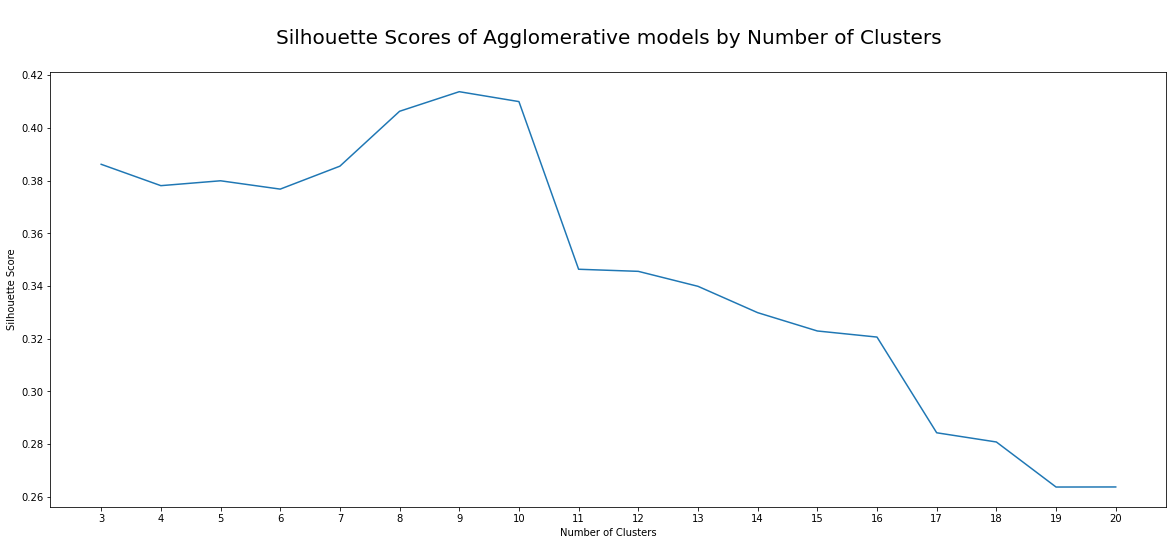

In [ ]:
plt.plot(*zip(*sorted(ag_silhouettes.items())))
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.gcf().set_size_inches(20, 8)
plt.title('\nSilhouette Scores of Agglomerative models by Number of Clusters\n', fontsize=20)
plt.show()

In [ ]:
ag_cluster = AgglomerativeClustering(n_clusters=max(ag_silhouettes, key=ag_silhouettes.get))
labels = ag_cluster.fit_predict(q5_successful_treatments)

Both DBSCAN and Agglomerative Clustering don't support the predict() method because due to the way both work, the points would change.  Thus, our method would not work for these algorithms and we should choose K-Means

#### K-Means with PCA

In [ ]:
q5_scaled = scaler.fit_transform(q5_successful_treatments)
pca_q5 = PCA(n_components=7)
pca_q5.fit(q5_scaled)

PCA(n_components=7)

In [ ]:
pca_silhouettes = dict()
pca_inertias = dict()

for x in n_clusters:
  pca_cluster = KMeans(n_clusters=x, random_state=seed)
  pca_labels = pca_cluster.fit_predict(pca_q5.transform(q5_scaled))
  pca_silhouettes[x] = silhouette_score(pca_q5.transform(q5_scaled), pca_labels)
  pca_inertias[x] = pca_cluster.inertia_

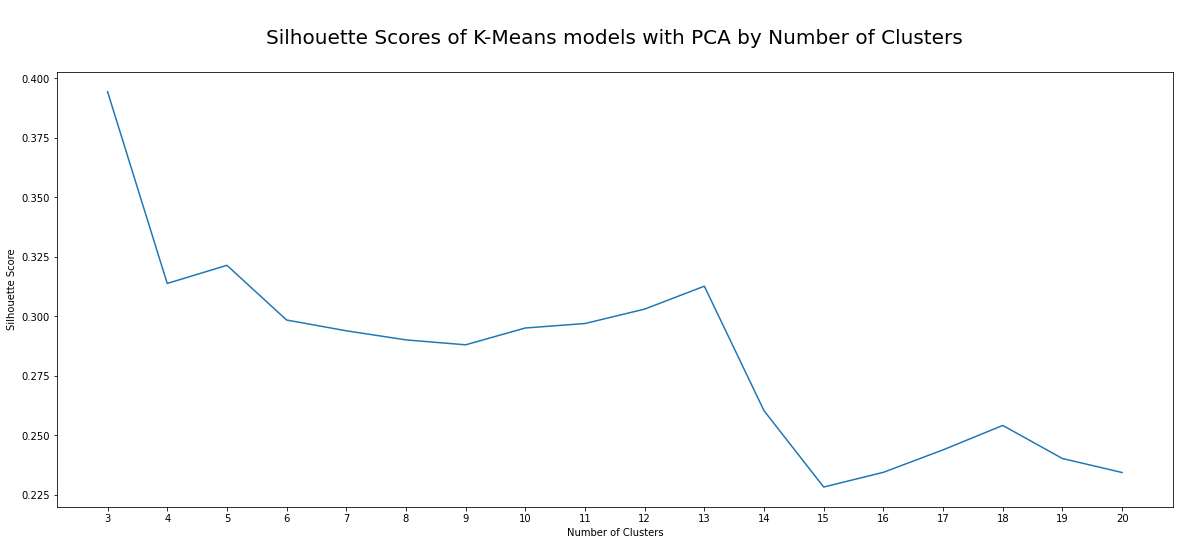

In [ ]:
plt.plot(*zip(*sorted(pca_silhouettes.items())))
plt.xticks(n_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.gcf().set_size_inches(20, 8)
plt.title('\nSilhouette Scores of K-Means models with PCA by Number of Clusters\n', fontsize=20)
plt.show()

Finally we can test a supervised method

#### CatBoostClassifier

In [ ]:
q5_classify = q5_successful_treatments.drop(['ReceivingLastOrCurrentTrmt', 'successful_treatment'], axis=1).astype('int').copy()

In [ ]:
q5_classify.TXLTYMNPL2.value_counts()

3     54
2     45
8     44
4     27
6     22
7     18
65    17
1     14
9     12
0      7
41     6
48     6
5      4
45     3
40     3
49     3
42     2
66     1
Name: TXLTYMNPL2, dtype: int64

In [ ]:
q5_classify_X_train, q5_classify_X_test, q5_classify_y_train, q5_classify_y_test = train_test_split(q5_classify.drop('TXLTYMNPL2', axis=1), q5_classify.TXLTYMNPL2, random_state=seed, test_size=0.2)
q5_classify_X_train, q5_classify_X_eval, q5_classify_y_train, q5_classify_y_eval = train_test_split(q5_classify_X_train, q5_classify_y_train, random_state=seed, test_size=0.2)

In [ ]:
cat_columns_classify = [x for x in range(len(q5_classify_X_train.columns)) if len(q5_classify_X_train[q5_classify_X_train.columns[x]].unique()) < 25]
classify_train_pool = Pool(q5_classify_X_train, q5_classify_y_train, cat_features=cat_columns_classify)
classify_test_pool = Pool(q5_classify_X_test, q5_classify_y_test, cat_features=cat_columns_classify) 
classify_eval_pool = Pool(q5_classify_X_eval, q5_classify_y_eval, cat_features=cat_columns_classify)

In [ ]:
classifier_model = CatBoostClassifier(iterations=500,
                           depth=10,
                           # learning_rate=1e-1,
                           loss_function='MultiClass',
                           verbose=True, use_best_model=True, early_stopping_rounds=2, random_seed=seed)

# task_type="GPU", devices='0:1'

In [ ]:
# grid = {'learning_rate': [5e-2, 0.1, 1], 'depth': [4, 6, 8, 10]}

In [ ]:
# classifier_model.grid_search(grid, classify_train_pool, cv=3)

In [ ]:
classifier_model.fit(classify_train_pool, eval_set=classify_eval_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.136025
0:	learn: 2.8287450	test: 2.8764257	best: 2.8764257 (0)	total: 15.1s	remaining: 2h 5m 49s
1:	learn: 2.6872604	test: 2.7181610	best: 2.7181610 (1)	total: 16s	remaining: 1h 6m 22s
2:	learn: 2.5659840	test: 2.5986456	best: 2.5986456 (2)	total: 16.2s	remaining: 44m 42s
3:	learn: 2.4989798	test: 2.5828374	best: 2.5828374 (3)	total: 38.9s	remaining: 1h 20m 28s
4:	learn: 2.4354768	test: 2.5225320	best: 2.5225320 (4)	total: 39s	remaining: 1h 4m 19s
5:	learn: 2.3810123	test: 2.4758806	best: 2.4758806 (5)	total: 39.9s	remaining: 54m 48s
6:	learn: 2.3382106	test: 2.4358898	best: 2.4358898 (6)	total: 59.4s	remaining: 1h 9m 43s
7:	learn: 2.2959465	test: 2.4146033	best: 2.4146033 (7)	total: 1m 18s	remaining: 1h 20m
8:	learn: 2.2443830	test: 2.3891198	best: 2.3891198 (8)	total: 1m 34s	remaining: 1h 25m 47s
9:	learn: 2.1961645	test: 2.3705050	best: 2.3705050 (9)	total: 1m 53s	remaining: 1h 32m 22s
10:	learn: 2.1532146	test: 2.3645634	best: 2.3645634 (10)	total: 2m 10s	rem

In [ ]:
classifier_model.score(classify_test_pool)

0.3103448275862069

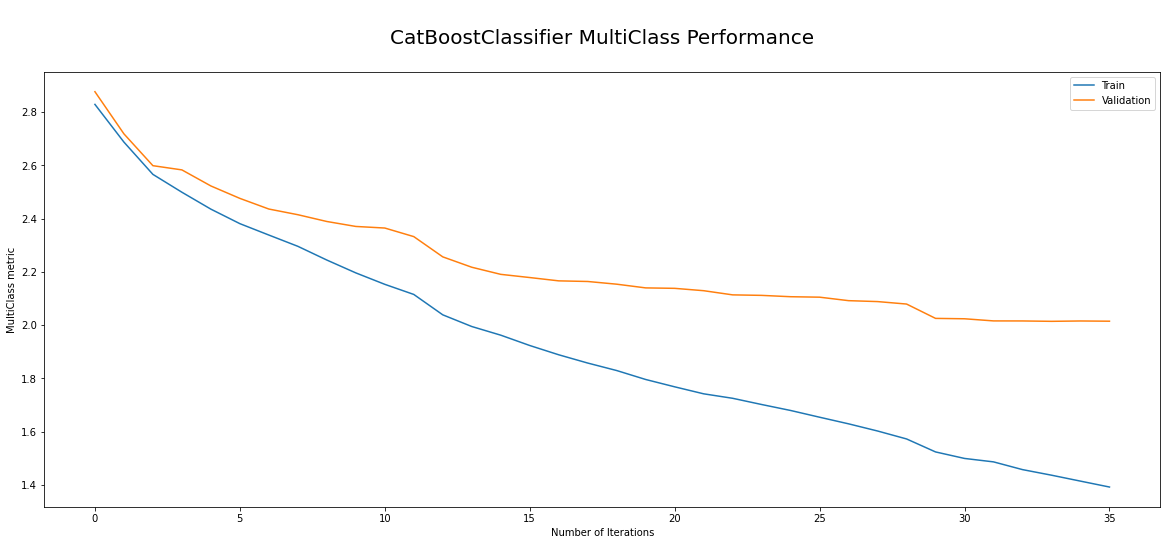

In [ ]:
plt.plot(classifier_model.get_evals_result()['learn']['MultiClass'], label="Train")
plt.plot(classifier_model.get_evals_result()['validation']['MultiClass'], label="Validation")
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('MultiClass metric')
plt.gcf().set_size_inches(20, 8)
plt.title('\nCatBoostClassifier MultiClass Performance\n', fontsize=20)
plt.show()

Note the overfitting

In [ ]:
preds_class = classifier_model.predict(classify_test_pool)
preds_proba = classifier_model.predict_proba(classify_test_pool)

Let's try implementing SMOTE

In [ ]:
q5_classify.TXLTYMNPL2.value_counts()

3     54
2     45
8     44
4     27
6     22
7     18
65    17
1     14
9     12
0      7
41     6
48     6
5      4
45     3
40     3
49     3
42     2
66     1
Name: TXLTYMNPL2, dtype: int64

In [ ]:
q5_classify_SMOTE = q5_classify[(q5_classify.TXLTYMNPL2 != 66) & (q5_classify.TXLTYMNPL2 != 42)].copy()

In [ ]:
X, y = imblearn.over_sampling.SMOTE(k_neighbors=2).fit_resample(q5_classify_SMOTE.drop(['TXLTYMNPL2'], axis=1), q5_classify_SMOTE.TXLTYMNPL2)

In [ ]:
y.value_counts()

4     54
2     54
7     54
8     54
6     54
0     54
3     54
48    54
40    54
65    54
1     54
5     54
9     54
45    54
41    54
49    54
Name: TXLTYMNPL2, dtype: int64

In [ ]:
smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=y)
smote_X_train, smote_X_eval, smote_y_train, smote_y_eval = train_test_split(smote_X_train, smote_y_train, random_state=seed, test_size=0.2, stratify=smote_y_train)

smote_train_pool = Pool(smote_X_train, smote_y_train, cat_features=cat_columns_classify)
smote_test_pool = Pool(smote_X_test, smote_y_test, cat_features=cat_columns_classify) 
smote_eval_pool = Pool(smote_X_eval, smote_y_eval, cat_features=cat_columns_classify)

In [ ]:
smote_model = CatBoostClassifier(iterations=500,
                           depth=6,
                           learning_rate=1e-1,
                           loss_function='MultiClass',
                           verbose=True, use_best_model=True, early_stopping_rounds=2, random_seed=seed)

In [ ]:
smote_model.fit(smote_train_pool, eval_set=smote_eval_pool)

0:	learn: 2.6804728	test: 2.6643544	best: 2.6643544 (0)	total: 926ms	remaining: 7m 42s
1:	learn: 2.5697418	test: 2.5624314	best: 2.5624314 (1)	total: 1.75s	remaining: 7m 15s
2:	learn: 2.5022288	test: 2.4962816	best: 2.4962816 (2)	total: 2.64s	remaining: 7m 17s
3:	learn: 2.4572205	test: 2.4606124	best: 2.4606124 (3)	total: 3.55s	remaining: 7m 20s
4:	learn: 2.3822351	test: 2.3947309	best: 2.3947309 (4)	total: 4.33s	remaining: 7m 8s
5:	learn: 2.3006177	test: 2.3200892	best: 2.3200892 (5)	total: 4.88s	remaining: 6m 41s
6:	learn: 2.2158806	test: 2.2381418	best: 2.2381418 (6)	total: 5.85s	remaining: 6m 52s
7:	learn: 2.1782830	test: 2.2035694	best: 2.2035694 (7)	total: 6.83s	remaining: 6m 59s
8:	learn: 2.1385352	test: 2.1674363	best: 2.1674363 (8)	total: 7.71s	remaining: 7m
9:	learn: 2.0729064	test: 2.0997584	best: 2.0997584 (9)	total: 8.83s	remaining: 7m 12s
10:	learn: 2.0118606	test: 2.0472124	best: 2.0472124 (10)	total: 9.85s	remaining: 7m 17s
11:	learn: 1.9636363	test: 2.0095112	best: 2.0

In [ ]:
smote_model.score(smote_test_pool)

0.7225433526011561

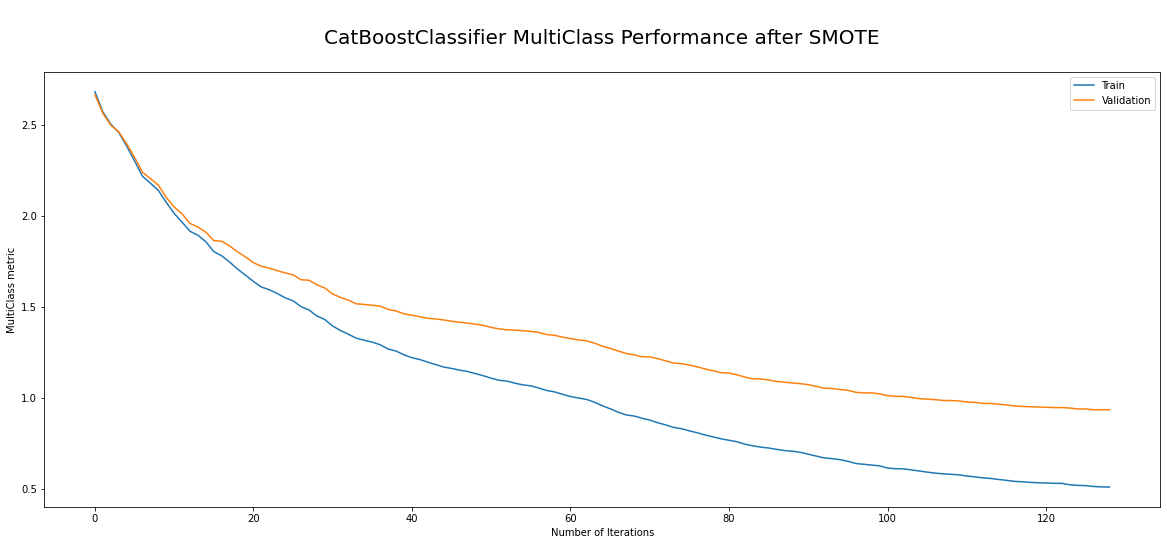

In [ ]:
plt.plot(smote_model.get_evals_result()['learn']['MultiClass'], label="Train")
plt.plot(smote_model.get_evals_result()['validation']['MultiClass'], label="Validation")
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('MultiClass metric')
plt.gcf().set_size_inches(20, 8)
plt.title('\nCatBoostClassifier MultiClass Performance after SMOTE\n', fontsize=20)
plt.show()

In [ ]:
cm = get_confusion_matrix(smote_model, smote_test_pool)

In [ ]:
TXLTYMNPL2_dict

{0: 'Treatment Unknown',
 1: 'A hospital overnight as an inpatient',
 2: 'A res drug/alcohol rehab facility overnight',
 3: 'A drug or alcohol rehab facility as an outpatient',
 4: 'A mental health center or facility as outpatient',
 5: 'An emergency room',
 6: "A private doctor's office",
 7: 'A prison or jail',
 8: 'Self-help group, Alcoholic/Narcotics Anonymous',
 9: 'Some other place',
 40: 'Home, family, friends',
 41: 'School, college',
 42: 'Church/religious/spiritual influence',
 44: 'Halfway house/group home',
 45: 'Rehab/intervention fac/prgrm, ptnt status unspcfd',
 47: 'Communty/city/county/state pgm or facil; unspecfd',
 48: 'Counselor, therapist, psychologist, psychiatrist',
 49: 'Court-mandated/sponsored program',
 64: 'Methadone clinic/program',
 65: 'Name of facility/program given',
 66: 'Faith-based formal program/facility'}

Text(32.999999999999986, 0.5, 'Treatment')

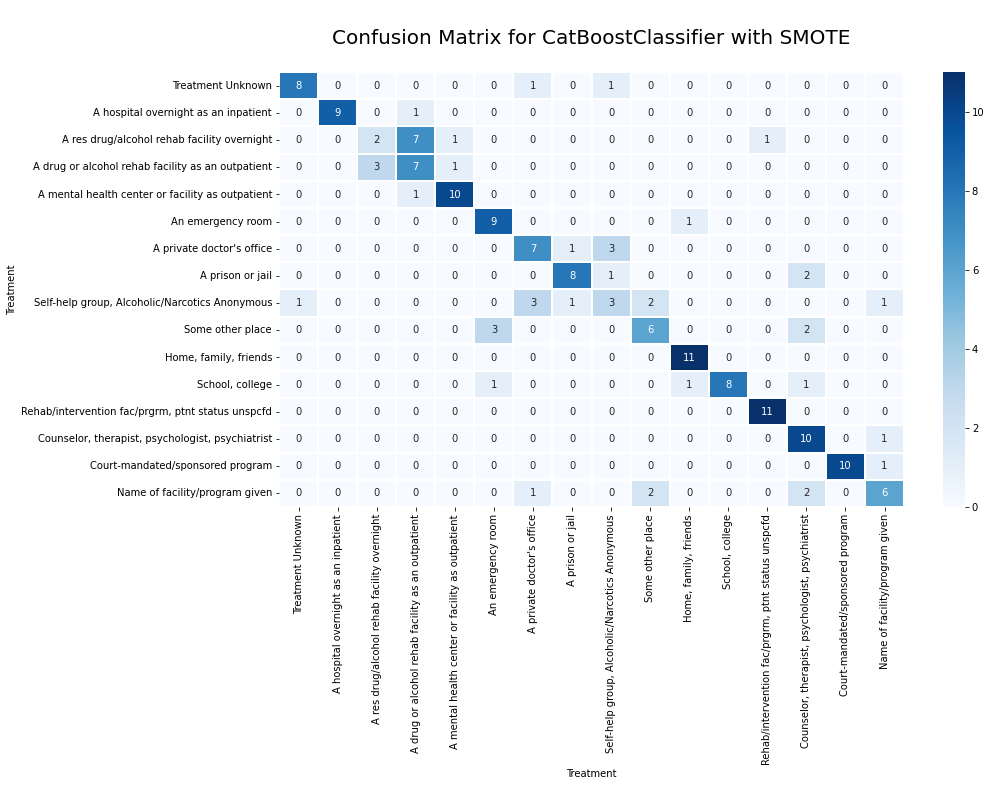

In [ ]:
sns.heatmap(cm, annot=True, linewidth=1, cmap='Blues', xticklabels=[TXLTYMNPL2_dict[x] for x in np.sort(y.unique())], yticklabels=[TXLTYMNPL2_dict[x] for x in np.sort(y.unique())])
plt.gcf().set_size_inches(14, 8)
plt.title('\nConfusion Matrix for CatBoostClassifier with SMOTE\n', fontsize=20)
plt.xlabel("Treatment")
plt.ylabel("Treatment")

In [ ]:
[TXLTYMNPL2_dict[x] for x in np.sort(y.unique())]

['Treatment Unknown',
 'A hospital overnight as an inpatient',
 'A res drug/alcohol rehab facility overnight',
 'A drug or alcohol rehab facility as an outpatient',
 'A mental health center or facility as outpatient',
 'An emergency room',
 "A private doctor's office",
 'A prison or jail',
 'Self-help group, Alcoholic/Narcotics Anonymous',
 'Some other place',
 'Home, family, friends',
 'School, college',
 'Rehab/intervention fac/prgrm, ptnt status unspcfd',
 'Counselor, therapist, psychologist, psychiatrist',
 'Court-mandated/sponsored program',
 'Name of facility/program given']

In [ ]:
random_response = id[(id.past_month_freq_use > id.past_month_freq_use.median()*2) & 
   (id.ReceivingLastOrCurrentTrmt == 0)].drop(['ReceivingLastOrCurrentTrmt', 'TXLTYMNPL2'], axis=1).sample(1).astype('int').copy()

In [ ]:
TXLTYMNPL2_dict[smote_model.predict(random_response)[0][0]] 

"A private doctor's office"

In [ ]:
max(smote_model.eval_metrics(smote_test_pool, 'TotalF1')['TotalF1'])

0.7131636510784936

In [ ]:
# from google.colab import output
# output.disable_custom_widget_manager()

## References
https://www.datafiles.samhsa.gov/dataset/nsduh-2002-2019-ds0001-nsduh-2002-2019-ds0001

https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

https://www.statology.org/scree-plot-python/

https://seaborn.pydata.org/examples/many_pairwise_correlations.html

https://matplotlib.org/stable/tutorials/text/annotations.html

https://docs.dask.org/en/stable/delayed.html

https://stackoverflow.com/questions/62449644/multiple-insert-columns-if-not-exist-pandas

https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed

https://gist.github.com/aswalin/595ac73f91c6268f9ca449a4ee05dee1#file-catboost-ipynb